<a href="https://colab.research.google.com/github/nadirawijaya/Skripsi/blob/main/Copy_of_Skripsi_Nadira_V3REV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
  <h1><b>SKRIPSI</b></h1>
  <h2><b>Pengaruh Seleksi Fitur IGWO terhadap Kinerja Random Forest, CatBoost, dan XGBoost<br>untuk Klasifikasi Penyakit Monkeypox Berdasarkan Gejala</b></h2>


  <br><br>
  <b>Diajukan oleh:</b><br>
  Nadira Putri Wijaya<br>
  2106635190<br>
  <a href="mailto:nadira.putri11@ui.ac.id">nadira.putri11@ui.ac.id</a>
  <br><br>

  <b>Dosen Pembimbing:</b><br>
  Dra. Bevina Desjwiandra Handari, M.Sc., Ph.D.
  <br><br><br>

  <b>Program Studi Sarjana Matematika</b><br>
  Departemen Matematika FMIPA Universitas Indonesia<br>
  Depok, Desember 2025
</center>


In [1]:
# =============================================================================
# STEP 1: INISIALISASI PIPELINE & MANAJEMEN PUSTAKA
# =============================================================================

# =============================================================================
# STEP 1A: INSTALASI PUSTAKA YANG DIBUTUHKAN
# =============================================================================
import sys

# Cek apakah kode dijalankan di Google Colab untuk instalasi otomatis
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    print("📦 Lingkungan Google Colab terdeteksi. Menginstal paket yang dibutuhkan...")
    # Instalasi dalam mode senyap (-q) untuk output yang bersih
    !pip install pandas numpy matplotlib seaborn scikit-learn imblearn chardet catboost xgboost -q
    print("✅ Paket instalasi selesai!")
else:
    print("📘 Menjalankan di lingkungan lokal. Pastikan semua paket sudah terinstal.")

# =============================================================================
# STEP 1B: INISIALISASI PIPELINE & MANAJEMEN PUSTAKA
# =============================================================================

# === 1.1 MANAJEMEN PUSTAKA & SISTEM ===
import warnings
import sys
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet

from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier # Sekarang ini tidak akan error

# Mengelola peringatan agar output lebih bersih
warnings.filterwarnings('ignore')

# === 1.2 HEADER & PENGECEKAN LINGKUNGAN ===
print("🚀 Menginisialisasi Pipeline Preprocessing Monkeypox...")
print("="*80)

# Cek lagi untuk memastikan modul files diimpor jika di Colab
if 'google.colab' in sys.modules:
    from google.colab import files

print("\n📚 Semua pustaka berhasil diimpor.")

# === 1.3 KONFIGURASI VISUALISASI & DISPLAY ===
plt.style.use('seaborn-v0_8-whitegrid')  # Gaya plot modern & konsisten
sns.set_palette("viridis")               # Palet warna default yang menarik
pd.set_option('display.max_columns', 50) # Tampilkan hingga 50 kolom di output
pd.set_option('display.width', 120)      # Lebar tampilan output Pandas

print("🎨 Pengaturan visualisasi dan display telah diterapkan.")
print("="*80)
print("✅ STEP 1 SELESAI: Pipeline siap untuk memuat data.")
print("="*80)

📦 Lingkungan Google Colab terdeteksi. Menginstal paket yang dibutuhkan...
✅ Paket instalasi selesai!
🚀 Menginisialisasi Pipeline Preprocessing Monkeypox...

📚 Semua pustaka berhasil diimpor.
🎨 Pengaturan visualisasi dan display telah diterapkan.
✅ STEP 1 SELESAI: Pipeline siap untuk memuat data.


In [2]:
# =============================================================================
# STEP 2: LOAD & CLEAN DATA (FINAL "STRICT CLINICAL SYMPTOM" STRATEGY)
# =============================================================================
import pandas as pd
import numpy as np
import sys
import re
import chardet
from IPython.display import display

# --- Pastikan modul Colab dikenali ---
if 'google.colab' in sys.modules:
    from google.colab import files

# === 2.1 LOADER & CLEANER CLASSES ===
class EnhancedCSVLoader:
    """Loader CSV yang sudah disederhanakan dan lebih tangguh."""
    def load_csv(self, file_path):
        print(f"🔄 Loading CSV: '{file_path}'...")
        encoding = 'utf-8'
        try:
            with open(file_path, 'rb') as f:
                encoding = chardet.detect(f.read(30000))['encoding']
        except Exception:
            print("   - Warning: Gagal deteksi encoding, default ke utf-8.")

        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"✅ Berhasil load. Bentuk awal: {df.shape}")
            return df
        except Exception:
            try:
                print(f"   - Gagal dengan encoding '{encoding}', mencoba fallback 'latin1'...")
                df = pd.read_csv(file_path, encoding='latin1')
                print(f"✅ Berhasil load dengan fallback 'latin1'. Bentuk awal: {df.shape}")
                return df
            except Exception as e2:
                print(f"❌ Gagal load: {e2}"); return None

class DataCleaner:
    """Membersihkan data dengan strategi 'whitelist' yang paling ketat pada gejala klinis."""
    def __init__(self, df):
        self.df = df.copy()

    def run_cleaning(self):
        print("\\n" + "🧼"*40 + "\\nDATA CLEANING & FEATURE SELECTION (STRICT ANTI-LEAKAGE)\\n" + "🧼"*40)
        self._clean_column_names()
        self._remove_non_predictive_ids()
        self._handle_duplicates()
        self._apply_strict_symptom_whitelist() # <-- Perubahan utama di sini
        self._display_overview()
        return self.df

    def _clean_column_names(self):
        print("🧹 1. Cleaning Column Names...")
        cleaned_columns = {}
        for col in self.df.columns:
            new_col = col.replace('\n', ' ').strip().lower()
            new_col = re.sub(r'\s*\(.*\)\s*', '', new_col) # Hapus teks dalam kurung
            new_col = new_col.replace(' ', '_').replace('/', '_')
            new_col = re.sub(r'[^a-z0-9_]', '', new_col)
            cleaned_columns[col] = new_col
        self.df.rename(columns=cleaned_columns, inplace=True)
        print("   - Nama kolom berhasil dibersihkan.")
        return self

    def _remove_non_predictive_ids(self):
        print("🆔 2. Removing ID Columns...")
        id_cols = ['id', 'patient_id']
        self.df.drop(columns=[c for c in id_cols if c in self.df.columns], inplace=True, errors='ignore')
        return self

    def _handle_duplicates(self):
        print("🛡️ 3. Handling Duplicates...")
        n_dupes = self.df.duplicated().sum()
        self.df.drop_duplicates(keep='first', inplace=True)
        print(f"   - Dihapus {n_dupes} baris duplikat.")
        return self

    def _apply_strict_symptom_whitelist(self):
        print("🔥 4. Applying Final Strict Symptom Whitelist to Eliminate All Data Leakage")

        # =============================================================================
        # === REVISI FINAL: WHITELIST PALING KETAT UNTUK HASIL YANG VALID ===
        # =============================================================================
        # Daftar ini adalah versi paling murni, hanya menyertakan gejala klinis
        # yang tidak ambigu dan demografi dasar. Semua potensi kebocoran data,
        # termasuk dari kategori 'unknown', telah dihilangkan.

        feature_whitelist = [
            # === GEJALA SISTEMIK / PRODROMAL ===
            'fever',
            'headache',
            'myalgia',
            'back_pain',
            'chills',
            'sore_throat',
            'systemic_illness', # Proxy untuk 'asthenia' / kelelahan

            # === GEJALA KHAS / LOKAL ===
            'lymphadenopathy',
            'dysuria',
            'rectal_pain_or_pain_on_defecation',
            'bleeding_discharge_per_rectum',
            'conjunctivitis',

            # === DEMOGRAFI DASAR ===
            'age',
            'sex',

            # === TARGET ===
            'diagnosing'
        ]

        # MENGAPA FITUR LAIN DIHAPUS:
        # - oropharyngeal_manifestations: DIHAPUS karena kategori 'unknown' terbukti menjadi
        #   sumber utama kebocoran data (data leakage), yang membuat model mendapat skor sempurna
        #   secara tidak realistis.
        # - hiv_..., smallpox_vaccination...: Bukan gejala, melainkan riwayat medis yang bocor.
        # - ...lesions, complications..., ...dna_detected...: Outcome, bukan prediktor.
        # - ..._rank, country..., travel...: Data epidemiologis, bukan gejala.
        # =============================================================================

        existing_features = [col for col in feature_whitelist if col in self.df.columns]
        missing_in_df = [col for col in feature_whitelist if col not in self.df.columns]

        if missing_in_df:
            print(f"   - Peringatan: Fitur berikut ada di whitelist tapi tidak ada di data Anda: {missing_in_df}")

        print(f"   - Mempertahankan {len(existing_features)} fitur dari whitelist paling ketat.")
        print(f"   - Menghapus {self.df.shape[1] - len(existing_features)} fitur lainnya.")

        self.df = self.df[existing_features]
        return self

    def _display_overview(self):
        print("📊 5. Final Overview after Strict Cleaning:")
        print(f"   - Final data shape: {self.df.shape}")
        display(self.df.head())

# =============================================================================
# MAIN FUNCTION & EXECUTION
# =============================================================================
def main_data_loader_and_cleaner():
    print("🚀 Memulai Pipeline Data Loading & Cleaning..."); print("="*80)
    df = None
    if 'google.colab' in sys.modules:
        try:
            print("\\n📤 Silakan upload CSV Anda..."); uploaded = files.upload()
            if not uploaded: print("🚫 Tidak ada file diupload."); return None
            file_name = next(iter(uploaded))
            df = EnhancedCSVLoader().load_csv(file_name)
        except Exception as e: print(f"💥 Error saat upload: {e}"); return None
    else:
        file_name = 'MonkeyPox Dataset Skripsi.csv'
        print(f"\\n📂 Running di environment lokal. Membaca file '{file_name}'")
        df = EnhancedCSVLoader().load_csv(file_name)

    if df is not None:
        if "Monkeypox" in df.columns:
            df.rename(columns={"Monkeypox": "diagnosing"}, inplace=True)
        return DataCleaner(df).run_cleaning()
    return None

# --- Jalankan pipeline utama ---
df_final_step2 = main_data_loader_and_cleaner()

# =============================================================================
# PEMISAHAN FITUR & TARGET
# =============================================================================
if df_final_step2 is not None:
    print("\\n" + "🎯"*40); print("FINALIZING STEP 2: SEPARATING FEATURES (X) AND TARGET (y)"); print("🎯"*40)
    TARGET_COLUMN = 'diagnosing'
    if TARGET_COLUMN in df_final_step2.columns:
        X_initial = df_final_step2.drop(columns=[TARGET_COLUMN], errors='ignore')
        y_initial = df_final_step2[TARGET_COLUMN]
        print(f"   - Target (y) ditetapkan sebagai: '{TARGET_COLUMN}'")
        print(f"\\n   - X_initial shape: {X_initial.shape}"); print(f"   - y_initial shape: {y_initial.shape}")
        print("\\n" + "✅"*60); print("STEP 2: DATA LOADING & CLEANING (STRICT ANTI-LEAKAGE) COMPLETED SUCCESSFULLY!"); print("✅"*60)
    else:
        print(f"🛑 GAGAL: Kolom target '{TARGET_COLUMN}' tidak ditemukan setelah pembersihan.")
else:
    print("\\n" + "🛑"*60); print("STEP 2 FAILED. Periksa error di atas sebelum melanjutkan."); print("🛑"*60)

🚀 Memulai Pipeline Data Loading & Cleaning...
\n📤 Silakan upload CSV Anda...


Saving MonkeyPox Dataset Skripsi.csv to MonkeyPox Dataset Skripsi (1).csv
🔄 Loading CSV: 'MonkeyPox Dataset Skripsi (1).csv'...
✅ Berhasil load. Bentuk awal: (500, 50)
\n🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼\nDATA CLEANING & FEATURE SELECTION (STRICT ANTI-LEAKAGE)\n🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼
🧹 1. Cleaning Column Names...
   - Nama kolom berhasil dibersihkan.
🆔 2. Removing ID Columns...
🛡️ 3. Handling Duplicates...
   - Dihapus 0 baris duplikat.
🔥 4. Applying Final Strict Symptom Whitelist to Eliminate All Data Leakage
   - Peringatan: Fitur berikut ada di whitelist tapi tidak ada di data Anda: ['systemic_illness']
   - Mempertahankan 14 fitur dari whitelist paling ketat.
   - Menghapus 35 fitur lainnya.
📊 5. Final Overview after Strict Cleaning:
   - Final data shape: (500, 14)


,fever,headache,myalgia,back_pain,chills,sore_throat,lymphadenopathy,dysuria,rectal_pain_or_pain_on_defecation,bleeding_discharge_per_rectum,conjunctivitis,age,sex,diagnosing
0,yes (2days),yes,yes,none,yes,yes,yes,none,yes,none,yes,49,female,positive
1,yes,none,none,yes,none,yes,none,yes,none,none,yes,52,female,positive
2,yes (4days),none,yes,yes,none,yes,yes,none,yes,yes,yes,76,male,positive
3,Coryzal illness (1 day),yes,none,yes,none,yes,none,yes,none,none,none,42,female,positive
4,yes (2days),none,yes,none,yes,yes,yes,yes,none,none,yes,67,male,positive


\n🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
FINALIZING STEP 2: SEPARATING FEATURES (X) AND TARGET (y)
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
   - Target (y) ditetapkan sebagai: 'diagnosing'
\n   - X_initial shape: (500, 13)
   - y_initial shape: (500,)
\n✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
STEP 2: DATA LOADING & CLEANING (STRICT ANTI-LEAKAGE) COMPLETED SUCCESSFULLY!
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅


In [3]:
# Menampilkan 10 baris pertama dari tabel fitur (X_initial)
display(X_initial.head(10))

# Menampilkan 10 baris pertama dari tabel target (y_initial)
display(y_initial.head(10))

,fever,headache,myalgia,back_pain,chills,sore_throat,lymphadenopathy,dysuria,rectal_pain_or_pain_on_defecation,bleeding_discharge_per_rectum,conjunctivitis,age,sex
0,yes (2days),yes,yes,none,yes,yes,yes,none,yes,none,yes,49,female
1,yes,none,none,yes,none,yes,none,yes,none,none,yes,52,female
2,yes (4days),none,yes,yes,none,yes,yes,none,yes,yes,yes,76,male
3,Coryzal illness (1 day),yes,none,yes,none,yes,none,yes,none,none,none,42,female
4,yes (2days),none,yes,none,yes,yes,yes,yes,none,none,yes,67,male
5,none,yes,yes,yes,yes,none,yes,yes,none,none,none,74,female
6,none,none,yes,yes,none,yes,yes,none,none,yes,yes,78,male
7,none,none,yes,none,none,yes,none,none,yes,none,yes,44,female
8,yes,none,none,yes,none,yes,none,yes,none,none,yes,50,male
9,none,yes,yes,yes,none,yes,none,none,none,none,none,18,male


,diagnosing
0,positive
1,positive
2,positive
3,positive
4,positive
5,positive
6,positive
7,positive
8,positive
9,negative


In [4]:
# =============================================================================
# STEP 3: DATA SPLITTING (TRAIN-VALIDATION-TEST)
# =============================================================================
from sklearn.model_selection import train_test_split  # Library untuk membagi dataset
import pandas as pd  # Library untuk manipulasi data
import numpy as np  # Library untuk operasi numerik

def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Splits the data into training, validation, and testing sets with stratification
    to maintain the same class proportion in each set.

    # Parameters:
    - X: DataFrame berisi fitur
    - y: Series target
    - train_size, val_size, test_size: Proporsi pembagian data
    - random_state: Seed untuk reproducibility

    # Returns:
    - X_train, X_validation, X_test, y_train, y_validation, y_test
    """
    print("\n" + "🔪"*40)
    print("STEP 3: SPLITTING DATA INTO TRAIN, VALIDATION, & TEST SETS")
    print("🔪"*40)

    # Check jika proporsi total = 1
    if not np.isclose(train_size + val_size + test_size, 1.0):
        print("🛑 ERROR: The sum of train, validation, and test sizes must be 1.0.")
        return None

    # --- First split ---
    # Pisahkan test set dari data (test_size = 0.15, stratify menjaga distribusi kelas target)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # --- Second split ---
    # Pisahkan training dan validation dari sisa data (train_val)
    val_proportion = val_size / (train_size + val_size)  # hitung proporsi relatif validation
    X_train, X_validation, y_train, y_validation = train_test_split(
        X_train_val, y_train_val, test_size=val_proportion, random_state=random_state, stratify=y_train_val
    )

    # Konfirmasi bahwa split berhasil
    print("✅ Data splitting successful.")
    print("\n" + "-"*40)
    print("Data Shapes:")
    print(f"   - Training Set   (X_train, y_train):      {X_train.shape}, {y_train.shape}  (~{train_size:.0%})")  # Tampilkan ukuran training
    print(f"   - Validation Set (X_validation, y_validation): {X_validation.shape}, {y_validation.shape}  (~{val_size:.0%})")  # Ukuran validation
    print(f"   - Test Set       (X_test, y_test):          {X_test.shape}, {y_test.shape}  (~{test_size:.0%})")  # Ukuran test
    print("-"*40)

    # --- Verifikasi stratifikasi ---
    # Menampilkan distribusi target di setiap set untuk memastikan representasi seimbang
    print("\nTarget Distribution Check:")
    print(f"   - Original:     \n{y.value_counts(normalize=True).sort_index().to_string()}")
    print(f"   - Training Set:   \n{y_train.value_counts(normalize=True).sort_index().to_string()}")
    print(f"   - Validation Set: \n{y_validation.value_counts(normalize=True).sort_index().to_string()}")
    print(f"   - Test Set:       \n{y_test.value_counts(normalize=True).sort_index().to_string()}")

    return X_train, X_validation, X_test, y_train, y_validation, y_test

# =============================================================================
# EXECUTION FOR STEP 3
# =============================================================================
# Step ini dijalankan setelah Step 2, menggunakan `X_initial` dan `y_initial`

if 'X_initial' in locals() and 'y_initial' in locals():
    # Split data dengan rasio 70/15/15 (train/validation/test)
    X_train, X_validation, X_test, y_train, y_validation, y_test = split_data(
        X_initial, y_initial, train_size=0.70, val_size=0.15, test_size=0.15
    )

    # Konfirmasi sukses split
    print("\n" + "🎉"*60)
    print("STEP 3 SUCCESS: Data has been split into three distinct sets.")
    print("The pipeline should now process X_train, X_validation, and X_test consistently in the next steps.")
    print("="*80)
else:
    print("🛑 Could not run Step 3 because `X_initial` and `y_initial` from Step 2 were not found.")  # Error handling



🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪
STEP 3: SPLITTING DATA INTO TRAIN, VALIDATION, & TEST SETS
🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪
✅ Data splitting successful.

----------------------------------------
Data Shapes:
   - Training Set   (X_train, y_train):      (350, 13), (350,)  (~70%)
   - Validation Set (X_validation, y_validation): (75, 13), (75,)  (~15%)
   - Test Set       (X_test, y_test):          (75, 13), (75,)  (~15%)
----------------------------------------

Target Distribution Check:
   - Original:     
diagnosing
negative    0.406
positive    0.594
   - Training Set:   
diagnosing
negative    0.405714
positive    0.594286
   - Validation Set: 
diagnosing
negative    0.413333
positive    0.586667
   - Test Set:       
diagnosing
negative    0.4
positive    0.6

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 3 SUCCESS: Data has been split into three distinct sets.
The pipeline should now process X_train, X_validation, and X_test consistently in t


🚀 STARTING STEP 4: VALUE STANDARDIZATION

✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
STEP 4: STANDARDIZING CATEGORICAL VALUES
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
1. Cleaning and standardizing values in Train, Validation, and Test sets...
   ✅ Standardization rules applied to 12 categorical columns.

📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
COMPREHENSIVE STANDARDIZATION REPORT (Based on Training Set)
📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
Found 12 column(s) with values that were standardized.

------------------------------------------------------------
🔎 Detailed Report for Column: 'fever'
   - Unique values reduced from 5 to 5.


,Before,After
fever,,
none,155,0
yes (2days),101,101
yes,37,37
Coryzal illness (1 day),30,0
yes (4days),27,27
no,0,155
coryzal illness (1 day),0,30


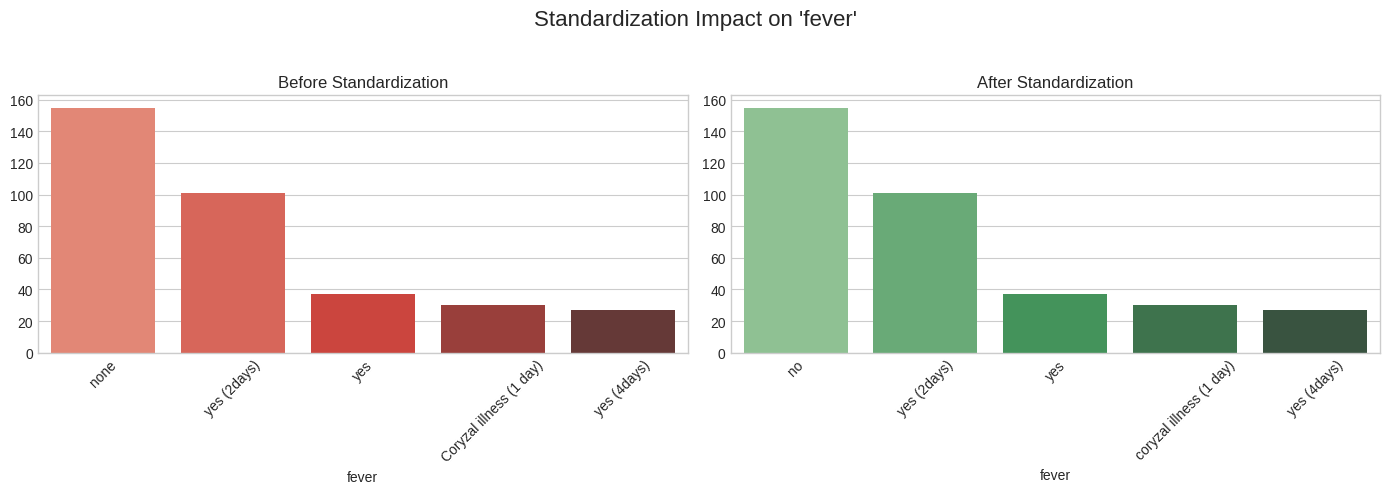


------------------------------------------------------------
🔎 Detailed Report for Column: 'headache'
   - Unique values reduced from 2 to 2.


,Before,After
headache,,
yes,271,271
none,79,0
no,0,79


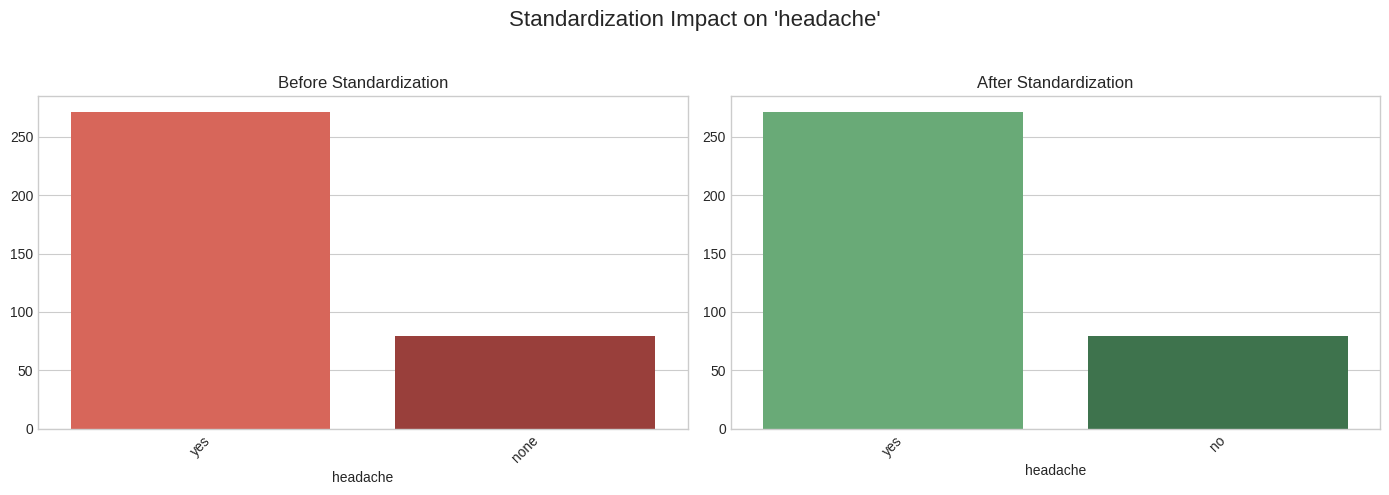


------------------------------------------------------------
🔎 Detailed Report for Column: 'myalgia'
   - Unique values reduced from 2 to 2.


,Before,After
myalgia,,
yes,280,280
none,70,0
no,0,70


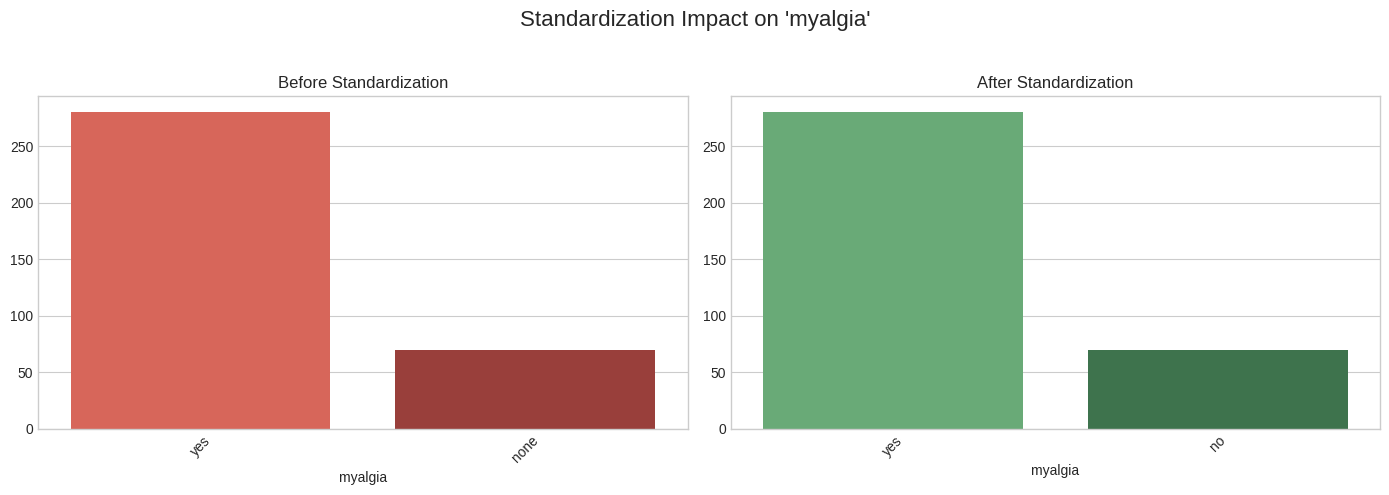


------------------------------------------------------------
🔎 Detailed Report for Column: 'back_pain'
   - Unique values reduced from 2 to 2.


,Before,After
back_pain,,
yes,240,240
none,110,0
no,0,110


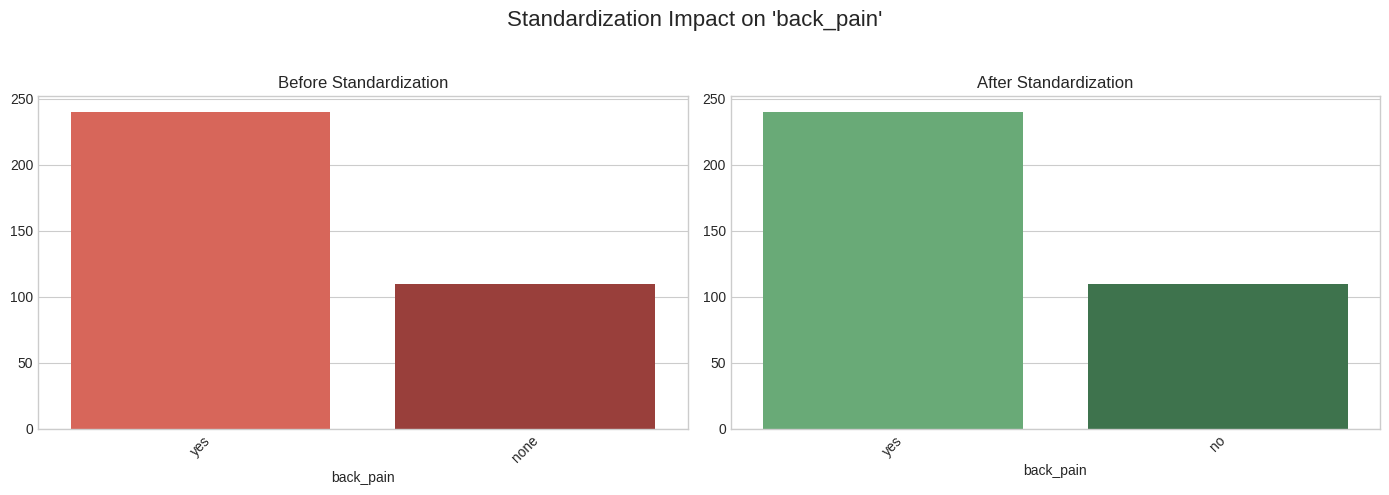


------------------------------------------------------------
🔎 Detailed Report for Column: 'chills'
   - Unique values reduced from 2 to 2.


,Before,After
chills,,
none,241,0
yes,109,109
no,0,241


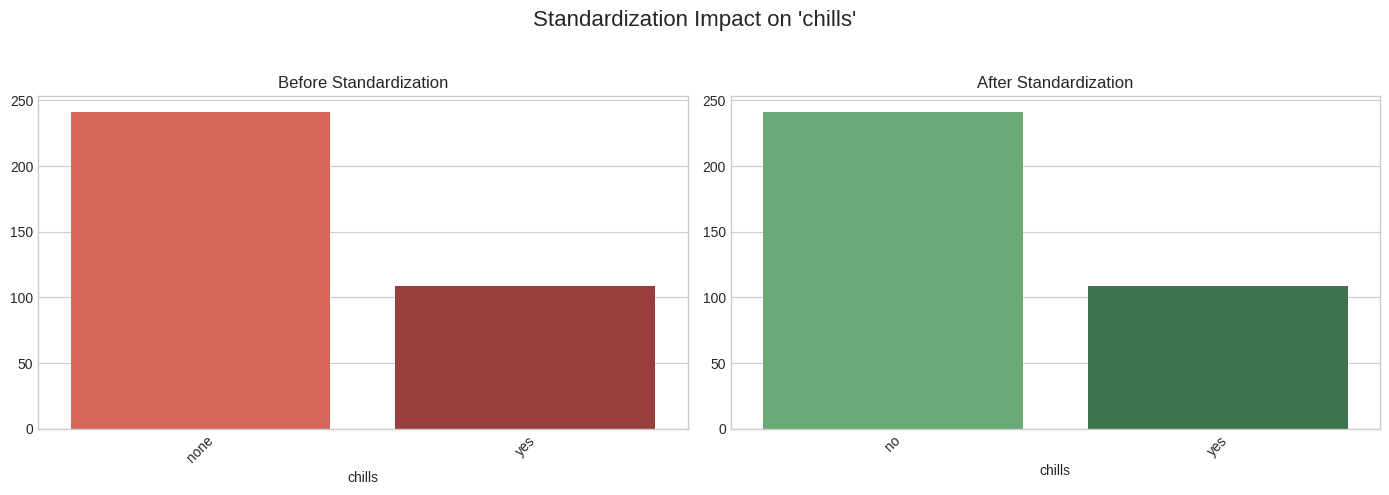


------------------------------------------------------------
🔎 Detailed Report for Column: 'sore_throat'
   - Unique values reduced from 2 to 2.


,Before,After
sore_throat,,
yes,254,254
none,96,0
no,0,96


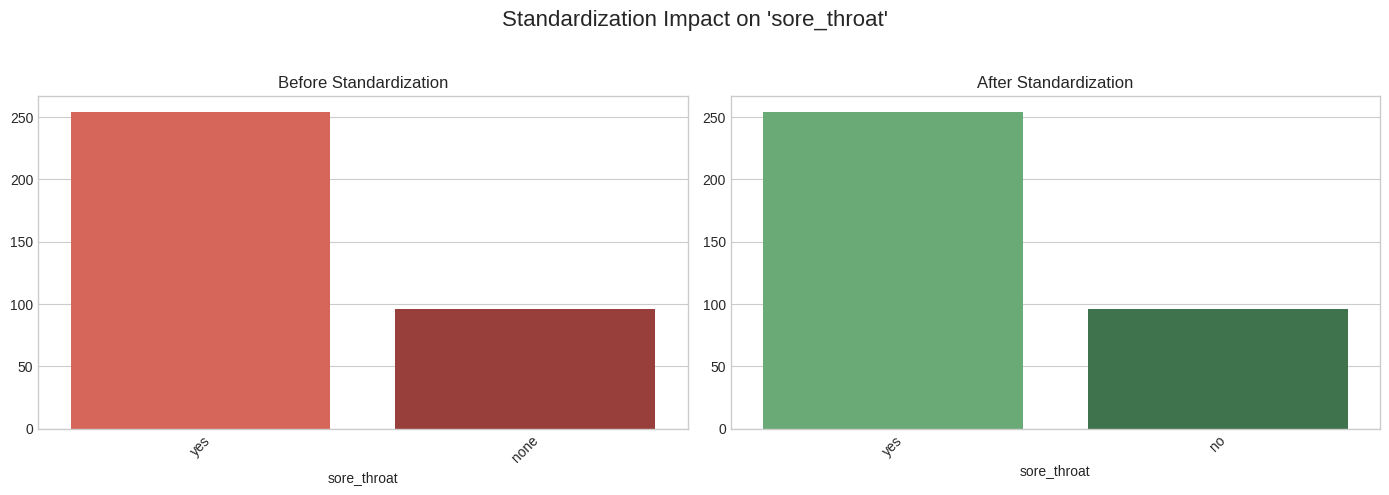


------------------------------------------------------------
🔎 Detailed Report for Column: 'lymphadenopathy'
   - Unique values reduced from 2 to 2.


,Before,After
lymphadenopathy,,
yes,228,228
none,122,0
no,0,122


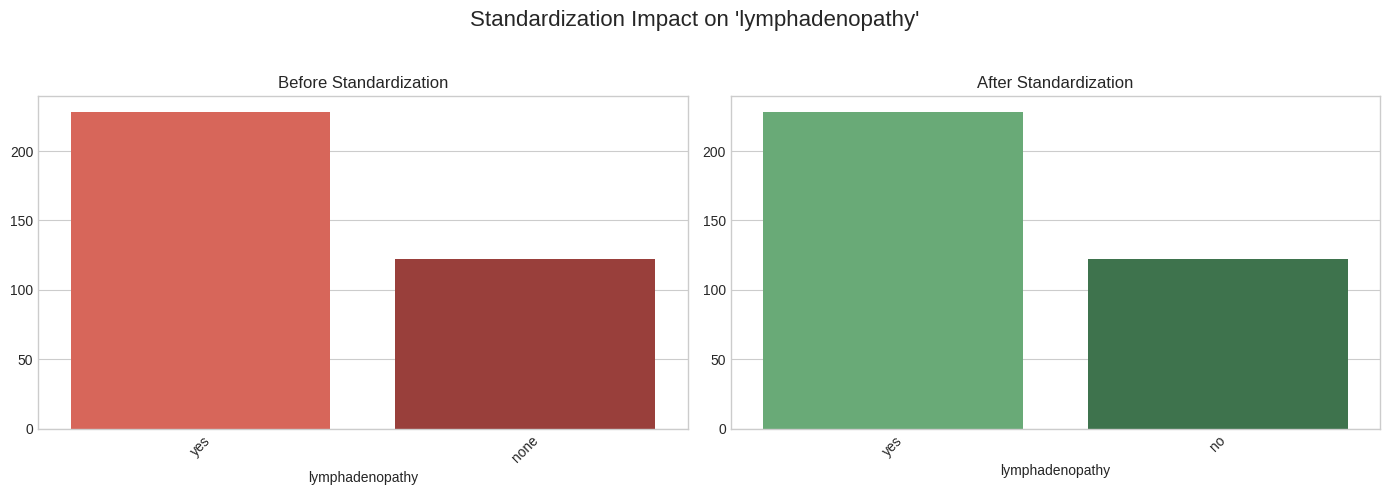


------------------------------------------------------------
🔎 Detailed Report for Column: 'dysuria'
   - Unique values reduced from 2 to 2.


,Before,After
dysuria,,
none,275,0
yes,75,75
no,0,275


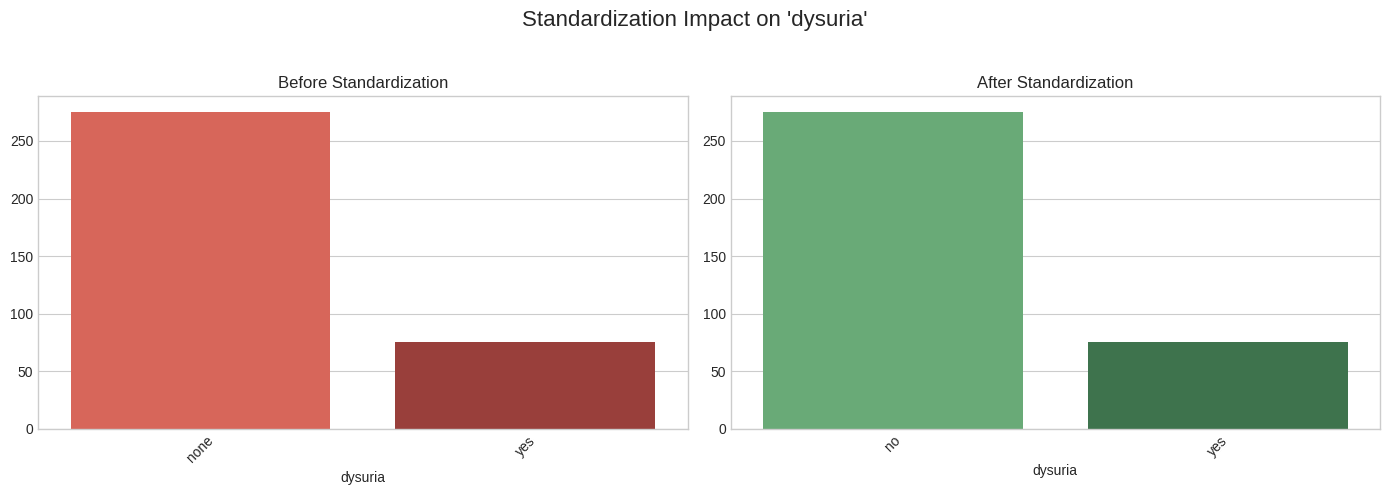


------------------------------------------------------------
🔎 Detailed Report for Column: 'rectal_pain_or_pain_on_defecation'
   - Unique values reduced from 2 to 2.


,Before,After
rectal_pain_or_pain_on_defecation,,
none,219,0
yes,131,131
no,0,219


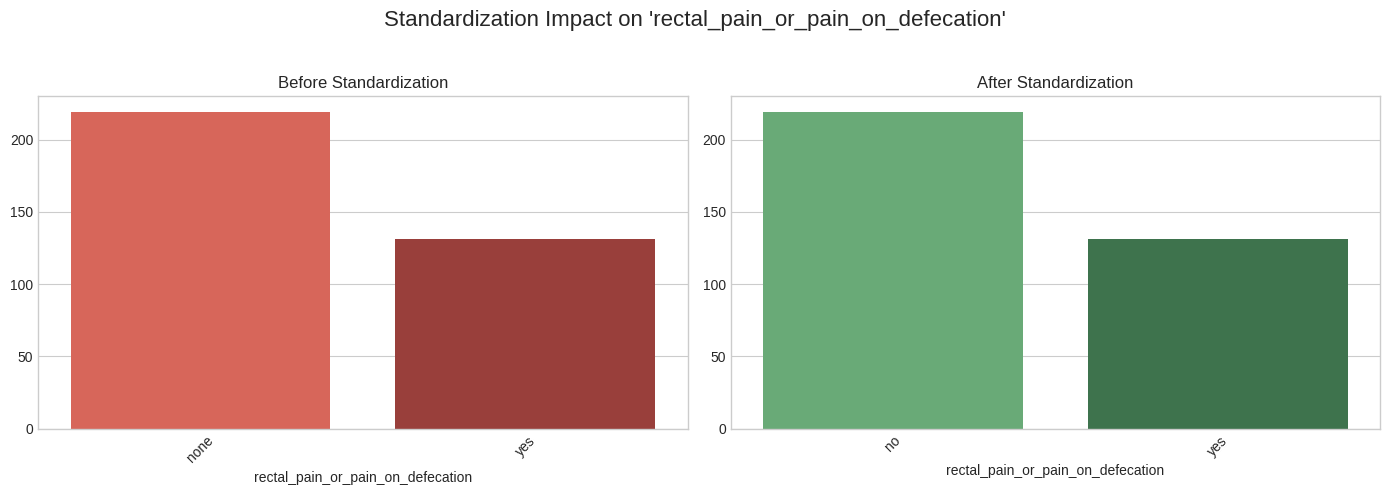


------------------------------------------------------------
🔎 Detailed Report for Column: 'bleeding_discharge_per_rectum'
   - Unique values reduced from 2 to 2.


,Before,After
bleeding_discharge_per_rectum,,
none,318,0
yes,32,32
no,0,318


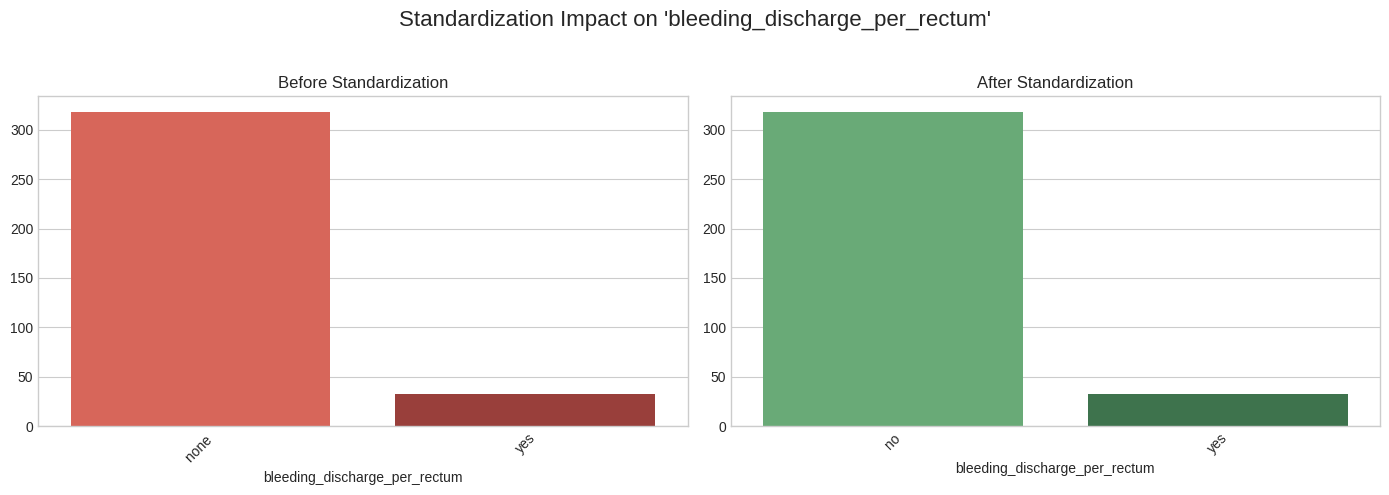


------------------------------------------------------------
🔎 Detailed Report for Column: 'conjunctivitis'
   - Unique values reduced from 2 to 2.


,Before,After
conjunctivitis,,
yes,178,178
none,172,0
no,0,172


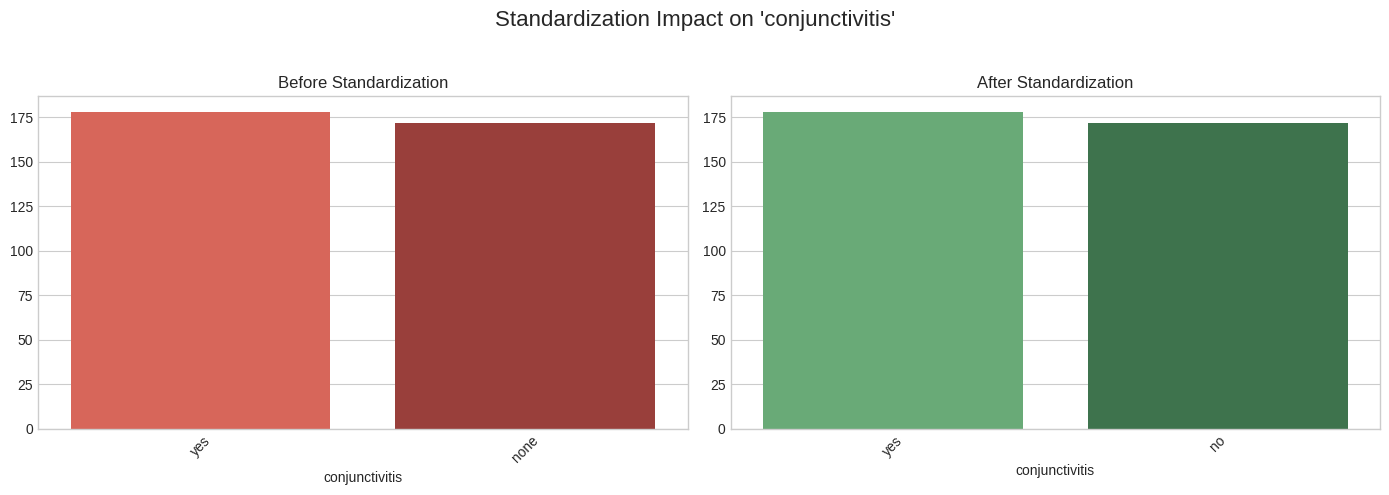


------------------------------------------------------------
🔎 Detailed Report for Column: 'sex'
   - Unique values reduced from 2 to 2.


,Before,After
sex,,
female,178,0
male,172,0
female,0,178
male,0,172


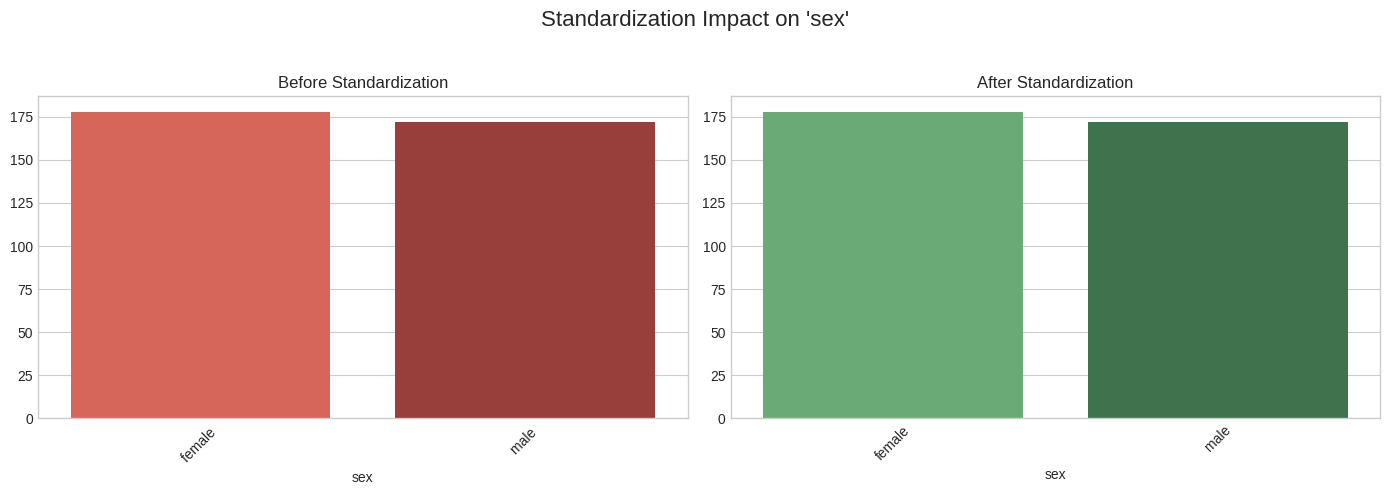


🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 4 SUCCESS: Categorical values have been consistently standardized across all data splits.
The data is now ready for missing value handling.
   - X_train_std shape: (350, 13)


In [5]:
# =============================================================================
# STEP 4: VALUE STANDARDIZATION
# =============================================================================
import pandas as pd  # Library manipulasi data
import numpy as np  # Library untuk operasi numerik
import matplotlib.pyplot as plt  # Library visualisasi
import seaborn as sns  # Library visualisasi
from IPython.display import display  # Menampilkan DataFrame dengan rapi di notebook

class ValueStandardizer:
    """
    Standardizes categorical values consistently across train, validation, and test sets
    with detailed, presentation-ready reporting.
    # Tujuan: Menghindari inkonsistensi kategori seperti "Yes"/"yes"/"Y"/"1" di seluruh dataset.
    """
    def __init__(self, X_train, X_validation, X_test):
        # Work on copies to avoid modifying original dataframes from previous steps
        self.X_train = X_train.copy()  # Copy data train
        self.X_validation = X_validation.copy()  # Copy data validation
        self.X_test = X_test.copy()  # Copy data test
        self.report_data = [] # Stores detailed change logs # Menyimpan perubahan untuk laporan visual

    def run_standardization(self):
        """Executes the entire standardization pipeline."""
        print("\n" + "✨"*40)
        print("STEP 4: STANDARDIZING CATEGORICAL VALUES")
        print("✨"*40)

        self._standardize_values()  # Terapkan standardisasi
        self._generate_report_and_visuals()  # Buat laporan dan visualisasi perubahan

        return self.X_train, self.X_validation, self.X_test  # Kembalikan dataset yang telah distandarisasi

    def _standardize_values(self):
        """Applies cleaning and standardization rules to all three data splits."""
        print("1. Cleaning and standardizing values in Train, Validation, and Test sets...")

        # Define comprehensive mapping rules for standardization
        replace_map = {
            'y': 'yes', 'true': 'yes', '1': 'yes', 'positive': 'yes', 'present': 'yes', 'detected': 'yes',  # Semua format 'yes'
            'n': 'no', 'false': 'no', '0': 'no', 'negative': 'no', 'absent': 'no', 'not detected': 'no', 'none': 'no',  # Semua format 'no'
            'm': 'male', 'man': 'male',  # Gender male
            'f': 'female', 'woman': 'female',  # Gender female
            'na': 'unknown', 'n/a': 'unknown', 'not specified': 'unknown', '?': 'unknown'  # Nilai tidak diketahui
        }

        # Identify categorical columns from the training set
        categorical_cols = self.X_train.select_dtypes(include=['object', 'category']).columns  # Deteksi kolom kategori

        # Apply the same transformations consistently to all three sets
        for df in [self.X_train, self.X_validation, self.X_test]:
            for col in categorical_cols:
                if col in df.columns:
                    # Capture state BEFORE for the training set report
                    if df is self.X_train:
                        before_counts = df[col].value_counts()  # Hitung distribusi awal

                    # Apply cleaning (strip whitespace, lowercase) and then replace using the map
                    df[col] = df[col].astype(str).str.strip().str.lower().replace(replace_map)  # Bersihkan dan standar

                    # Capture state AFTER for the training set report
                    if df is self.X_train:
                        after_counts = df[col].value_counts()  # Hitung distribusi setelah standar
                        # If any changes occurred, log them for the report
                        if not before_counts.equals(after_counts):
                            self.report_data.append({
                                'column': col,  # Nama kolom
                                'before_counts': before_counts,  # Distribusi sebelum standar
                                'after_counts': after_counts,  # Distribusi sesudah standar
                                'unique_before': len(before_counts),  # Jumlah nilai unik awal
                                'unique_after': len(after_counts)  # Jumlah nilai unik akhir
                            })

        print(f"   ✅ Standardization rules applied to {len(categorical_cols)} categorical columns.")  # Laporan jumlah kolom

    def _generate_report_and_visuals(self):
        """Generates a detailed, visual report of the standardization on the training set."""
        print("\n" + "📋"*40)
        print("COMPREHENSIVE STANDARDIZATION REPORT (Based on Training Set)")
        print("📋"*40)

        if not self.report_data:
            print("✅ No values required standardization. All categorical data is already clean.")  # Tidak ada perubahan
            return

        print(f"Found {len(self.report_data)} column(s) with values that were standardized.")  # Jumlah kolom yang berubah

        for report in self.report_data:
            col, before_df, after_df = report['column'], report['before_counts'].to_frame('Before'), report['after_counts'].to_frame('After')
            comparison_df = pd.concat([before_df, after_df], axis=1).fillna(0).astype(int)  # Gabungkan tabel before/after

            print("\n" + "-"*60)
            print(f"🔎 Detailed Report for Column: '{col}'")
            print(f"   - Unique values reduced from {report['unique_before']} to {report['unique_after']}.")  # Info ringkas
            display(comparison_df)  # Tampilkan tabel before/after

            # Create side-by-side visualizations
            fig, axes = plt.subplots(1, 2, figsize=(14, 5)); fig.suptitle(f"Standardization Impact on '{col}'", fontsize=16)
            sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Before Standardization"); axes[0].tick_params(axis='x', rotation=45)
            sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("After Standardization"); axes[1].tick_params(axis='x', rotation=45)
            plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()  # Visualisasi per kolom

# =============================================================================
# EXECUTION FOR STEP 4
# =============================================================================
# This step runs AFTER Step 3 (Data Splitting)
if 'X_train' in locals():
    print("\n" + "="*80)
    print("🚀 STARTING STEP 4: VALUE STANDARDIZATION")
    print("="*80)

    # Initialize the standardizer with the three data splits
    standardizer = ValueStandardizer(X_train, X_validation, X_test)  # Inisialisasi class

    # Run the process
    X_train_std, X_validation_std, X_test_std = standardizer.run_standardization()  # Jalankan standardisasi

    print("\n" + "🎉"*60)
    print("STEP 4 SUCCESS: Categorical values have been consistently standardized across all data splits.")  # Konfirmasi sukses
    print("The data is now ready for missing value handling.")  # Next step
    print(f"   - X_train_std shape: {X_train_std.shape}")  # Ukuran dataset
    print("="*80)
else:
    print("🛑 Could not run Step 4 because the split data (`X_train`, etc.) from Step 3 was not found.")  # Error handling


---
### **STEP 5: Analisis Karakteristik Fitur Kategorikal Awal (EDA)** 📊

Setelah data dibersihkan dan distandarisasi secara nilai, langkah selanjutnya adalah melakukan Analisis Data Eksplorasi (EDA) sederhana pada data latih. Tujuannya adalah untuk memahami karakteristik dasar dari setiap fitur kategorikal, terutama jumlah nilai unik (kardinalitas) yang dimilikinya.

Fitur dengan kardinalitas yang aneh atau nilai yang tidak konsisten seringkali memerlukan perhatian khusus pada tahap *feature engineering*.

In [6]:
# =============================================================================
# STEP 5: ANALISIS KARAKTERISTIK FITUR KATEGORIKAL
# =============================================================================
import pandas as pd

print("🔬 Menganalisis fitur-fitur kategorikal pada data latih (X_train_std)...")

# Pilih hanya kolom kategorikal (tipe 'object')
categorical_cols = X_train_std.select_dtypes(include=['object', 'category']).columns

# Buat DataFrame untuk menampung hasil analisis
analysis_list = []
for col in categorical_cols:
    unique_values = X_train_std[col].unique()
    num_unique = len(unique_values)
    analysis_list.append({
        'Nama Fitur': col,
        'Jumlah Nilai Unik': num_unique,
        'Contoh Nilai': list(unique_values[:3]) # Ambil 3 contoh
    })

df_cardinality_analysis = pd.DataFrame(analysis_list)

print("\n--- Hasil Analisis Kardinalitas Fitur Kategorikal ---")
display(df_cardinality_analysis.style.bar(subset=['Jumlah Nilai Unik'], color='#5fba7d'))

🔬 Menganalisis fitur-fitur kategorikal pada data latih (X_train_std)...

--- Hasil Analisis Kardinalitas Fitur Kategorikal ---


,Nama Fitur,Jumlah Nilai Unik,Contoh Nilai
0,fever,5,"['no', 'yes (2days)', 'coryzal illness (1 day)']"
1,headache,2,"['yes', 'no']"
2,myalgia,2,"['yes', 'no']"
3,back_pain,2,"['yes', 'no']"
4,chills,2,"['no', 'yes']"
5,sore_throat,2,"['no', 'yes']"
6,lymphadenopathy,2,"['yes', 'no']"
7,dysuria,2,"['no', 'yes']"
8,rectal_pain_or_pain_on_defecation,2,"['no', 'yes']"
9,bleeding_discharge_per_rectum,2,"['no', 'yes']"


In [7]:
# =============================================================================
# STEP 6: ANALISIS DIAGNOSTIK KOLOM 'fever' (FIXED)
# =============================================================================
import pandas as pd
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

print("🔬 Menganalisis distribusi nilai pada kolom 'fever' di data latih...")

# --- PERBAIKAN: Lakukan encoding target secara lokal untuk analisis ---
# Ini tidak akan mengganggu variabel y_train_encoded yang akan dibuat nanti di Step 7
le_diagnostic = LabelEncoder()
y_train_temp_encoded = le_diagnostic.fit_transform(y_train)
# ----------------------------------------------------------------------

# Gabungkan sementara fitur latih dengan target yang sudah di-encode untuk analisis
df_diagnostic = X_train_std.copy()
df_diagnostic['TARGET'] = y_train_temp_encoded # Gunakan variabel sementara

# Tampilkan value counts dari kolom 'fever'
print("\n--- Value Counts untuk Kolom 'fever' ---")
display(df_diagnostic['fever'].value_counts())

# Gunakan crosstab untuk melihat distribusi nilai 'fever' per kelas target
print("\n--- Distribusi 'fever' vs TARGET ---")
crosstab_fever = pd.crosstab(df_diagnostic['fever'], df_diagnostic['TARGET'])
# Beri nama kolom yang jelas menggunakan encoder lokal yang baru dibuat
crosstab_fever.columns = [le_diagnostic.classes_[0], le_diagnostic.classes_[1]]
display(crosstab_fever.style.background_gradient(cmap='summer'))

🔬 Menganalisis distribusi nilai pada kolom 'fever' di data latih...

--- Value Counts untuk Kolom 'fever' ---


,count
fever,
no,155
yes (2days),101
yes,37
coryzal illness (1 day),30
yes (4days),27



--- Distribusi 'fever' vs TARGET ---


,negative,positive
fever,,
coryzal illness (1 day),0,30
no,142,13
yes,0,37
yes (2days),0,101
yes (4days),0,27


In [8]:
# =============================================================================
# STEP 7: MISSING VALUE HANDLING (FINAL REVISION WITH SYNTAX FIX)
# =============================================================================
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

class ComprehensiveMissingValueHandler:
    """
    Analyzes missing values, then imputes them correctly on pre-split data
    using a revised logic to prevent data leakage.
    """
    def __init__(self):
        self.imputation_plan = None
        self.num_imputer = SimpleImputer(strategy='median')
        self.cat_imputer = SimpleImputer(strategy='most_frequent')
        self.num_cols_to_impute = []
        self.cat_cols_to_impute = []

    def run_pipeline(self, df_original, X_train, X_validation, X_test):
        """Executes the full analysis and imputation pipeline."""
        self._analyze_missing_values(X_train) # Analisis hanya di training data

        if self.imputation_plan is None or self.imputation_plan.empty:
            print("✅ No missing values to impute. Returning original data sets.")
            return X_train, X_validation, X_test

        return self._execute_imputation(X_train, X_validation, X_test)

    def _analyze_missing_values(self, df):
        """Performs analysis on the training data to generate an imputation plan."""
        print("\n" + "📊"*40)
        print("PART 1: DEEP ANALYSIS OF MISSING VALUES (PLANNING STAGE ON TRAINING DATA)")
        print("📊"*40)
        missing = df.isnull().sum()
        missing = missing[missing > 0]
        if missing.empty:
            self.imputation_plan = pd.DataFrame()
            return

        print(f"Found {len(missing)} columns with missing values. Generating analysis and strategy plan...")
        plan_details = [{
            'Column': col,
            'Missing Count': count,
            'Missing (%)': f"{(count / len(df)) * 100:.1f}%",
            'Data Type': str(df[col].dtype),
            'Recommended Strategy': "Median" if pd.api.types.is_numeric_dtype(df[col]) else "Mode"
        } for col, count in missing.items()]
        self.imputation_plan = pd.DataFrame(plan_details).sort_values(by='Missing Count', ascending=False)
        print("\n📋 Imputation Plan Summary:")
        display(self.imputation_plan.style.background_gradient(cmap='Reds', subset=['Missing Count']))
        self._create_advanced_missing_visualizations(df)

    def _create_advanced_missing_visualizations(self, df):
        print("\n📈 Generating Advanced Missing Value Visualizations...")
        fig, axes = plt.subplots(1, 2, figsize=(16, 6)); fig.suptitle('Missing Values Analysis on Training Data', fontsize=16)
        missing_df = self.imputation_plan
        sns.heatmap(df[missing_df['Column']].isnull(), cbar=False, cmap='viridis_r', ax=axes[0]); axes[0].set_title('Missing Values Heatmap Pattern')
        top_10 = missing_df.head(10)
        sns.barplot(x='Missing Count', y='Column', data=top_10, ax=axes[1], palette='viridis')
        axes[1].set_title('Top 10 Columns with Missing Values')
        plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

    def _execute_imputation(self, X_train, X_validation, X_test):
        """Executes the imputation using the correct anti-data leakage workflow."""
        print("\n" + "⚡"*40)
        print("PART 2: EXECUTING IMPUTATION ON SPLIT DATA (CORRECT LOGIC)")
        print("⚡"*40)

        self.num_cols_to_impute = self.imputation_plan[self.imputation_plan['Recommended Strategy'] == 'Median']['Column'].tolist()
        self.cat_cols_to_impute = self.imputation_plan[self.imputation_plan['Recommended Strategy'] == 'Mode']['Column'].tolist()

        self.num_cols_to_impute = [col for col in self.num_cols_to_impute if col in X_train.columns]
        self.cat_cols_to_impute = [col for col in self.cat_cols_to_impute if col in X_train.columns]

        X_train_imputed, X_validation_imputed, X_test_imputed = X_train.copy(), X_validation.copy(), X_test.copy()

        print("1. Fitting imputers ONLY on the TRAINING data...")
        if self.num_cols_to_impute:
            self.num_imputer.fit(X_train[self.num_cols_to_impute])
        if self.cat_cols_to_impute:
            self.cat_imputer.fit(X_train[self.cat_cols_to_impute])

        print("2. Transforming TRAIN, VALIDATION, and TEST data separately...")
        if self.num_cols_to_impute:
            X_train_imputed[self.num_cols_to_impute] = self.num_imputer.transform(X_train[self.num_cols_to_impute])
            X_validation_imputed[self.num_cols_to_impute] = self.num_imputer.transform(X_validation[self.num_cols_to_impute])
            X_test_imputed[self.num_cols_to_impute] = self.num_imputer.transform(X_test[self.num_cols_to_impute])
        if self.cat_cols_to_impute:
            X_train_imputed[self.cat_cols_to_impute] = self.cat_imputer.transform(X_train[self.cat_cols_to_impute])
            X_validation_imputed[self.cat_cols_to_impute] = self.cat_imputer.transform(X_validation[self.cat_cols_to_impute])
            X_test_imputed[self.cat_cols_to_impute] = self.cat_imputer.transform(X_test[self.cat_cols_to_impute])

        self._generate_imputation_report(X_train_imputed, X_validation_imputed, X_test_imputed)
        return X_train_imputed, X_validation_imputed, X_test_imputed

    def _generate_imputation_report(self, X_train, X_validation, X_test):
        print("\n" + "📋"*40)
        print("PART 3: IMPUTATION EXECUTION REPORT")
        print("📋"*40)
        print("\nFinal Verification:")
        print(f"   - Missing values remaining in X_train: {X_train.isnull().sum().sum()}")
        print(f"   - Missing values in X_validation: {X_validation.isnull().sum().sum()}")
        print(f"   - Missing values in X_test: {X_test.isnull().sum().sum()}")
        if X_train.isnull().sum().sum() == 0:
            print("   - ✅ SUCCESS. All missing values have been handled correctly.")
        else:
            print("   - ⚠️ WARNING. Some missing values remain.")

# =============================================================================
# EXECUTION FOR STEP 7
# =============================================================================
if 'X_train_std' in locals():
    print("\n" + "="*80)
    print("🚀 STARTING STEP 7: MISSING VALUE ANALYSIS & HANDLING")
    print("="*80)

    handler = ComprehensiveMissingValueHandler()

    # Menjalankan pipeline dengan input yang benar
    X_train_imputed, X_validation_imputed, X_test_imputed = handler.run_pipeline(
        df_final_step2, X_train_std, X_validation_std, X_test_std
    )

    print("\n" + "🎉"*60)
    print("STEP 7 SUCCESS: Missing values have been handled correctly across all data splits.")
    print("="*80)
else:
    print("🛑 Could not run Step 7 because the standardized data (`X_train_std`, etc.) from Step 4 was not found.")


🚀 STARTING STEP 7: MISSING VALUE ANALYSIS & HANDLING

📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
PART 1: DEEP ANALYSIS OF MISSING VALUES (PLANNING STAGE ON TRAINING DATA)
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
✅ No missing values to impute. Returning original data sets.

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 7 SUCCESS: Missing values have been handled correctly across all data splits.


<details>
<summary>📖 Penjelasan Step 6: Feature Engineering, Encoding, & Scaling</summary>

**Step 6** adalah tahap final preprocessing sebelum model training. Berikut rinciannya:

---

### 🔹 6.1 Feature Engineering
- Membuat fitur baru berdasarkan domain knowledge:
  - `symptom_score`: jumlah gejala 'yes' yang dialami pasien.
  - `symptom_severity`: kategori keparahan gejala berdasarkan kuantil train set.
  - `age_group`: kelompok umur berdasarkan batas tertentu (0–18, 19–40, 41–65, 66+).
- Semua fitur baru diterapkan konsisten ke **train, validation, dan test set**.

### 🔹 6.2 Encoding & Handling Cardinality
- Pisahkan kolom kategori menjadi:
  - **Low-cardinality (≤10 unique values)** → One-Hot Encoding (OHE).
  - **High-cardinality (>10 unique values)** → dihapus untuk menghindari sparsity.
- OHE **fit hanya di train set**, lalu transform diterapkan ke semua split.
- Menjamin tidak terjadi data leakage.

### 🔹 6.3 Scaling Numerical Features
- Semua fitur numerik di-scale menggunakan **StandardScaler**:
  - Fit hanya di train set.
  - Transform diterapkan ke train, validation, dan test set.
- Menjaga skala fitur agar model tidak bias terhadap range numerik tertentu.
- Statistik sebelum & sesudah scaling ditampilkan untuk monitoring.

### 🔹 6.4 Final Report
- Menampilkan shape final untuk **X_train_final, X_validation_final, X_test_final**.
- Menyediakan preview data train yang sudah siap untuk model training.

---

✅ Setelah Step 6, data sudah:
- Bebas missing values.
- Fitur kategori & numerik sudah siap.
- Split data konsisten untuk train, validation, dan test.
- Siap untuk proses model building atau evaluasi.

</details>


In [9]:
# =============================================================================
# STEP 8: FEATURE ENGINEERING, ENCODING, & SCALING (VERSI FINAL TERINTEGRASI)
# =============================================================================
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
import numpy as np
import re # Pastikan re di-import
from IPython.display import display

class FeaturePipeline:
    def __init__(self, X_train, X_validation, X_test):
        self.X_train = X_train.copy()
        self.X_validation = X_validation.copy()
        self.X_test = X_test.copy()
        self.learned_params = {}

    def run_pipeline(self):
        print("\n" + "🛠️"*40)
        print("STEP 8: FEATURE ENGINEERING, ENCODING, AND SCALING")
        print("🛠️"*40)

        # 1. Rekayasa fitur dari kolom 'fever'
        self._engineer_fever_features()
        # 2. Rekayasa fitur lainnya (skor gejala & grup umur)
        self._engineer_symptom_and_age_features()
        # 3. Lakukan encoding dan scaling
        self._encode_and_scale()

        self._generate_final_report()
        return self.X_train, self.X_validation, self.X_test

    def _engineer_fever_features(self):
        print("\n--- 8.1: Menerapkan Solusi untuk Fitur 'fever' ---")
        def transform_fever(df):
            df_engineered = df.copy()
            # Buat kolom baru numerik untuk durasi demam
            df_engineered['fever_duration_days'] = 0
            # Buat kolom baru kategorikal untuk keberadaan demam
            df_engineered['fever_presence'] = 'no'

            def extract_days(x):
                if isinstance(x, str) and '(' in x and 'day' in x:
                    try: return int(re.search(r'\((\d+)\s*day', x).group(1))
                    except: return 1
                return 0
            df_engineered['fever_duration_days'] = np.vectorize(extract_days)(df_engineered['fever'])

            def determine_presence(x):
                return 'yes' if isinstance(x, str) and ('yes' in x or 'coryzal' in x) else 'no'
            df_engineered['fever_presence'] = df_engineered['fever'].apply(determine_presence)

            # Hapus kolom 'fever' asli yang bermasalah
            df_engineered = df_engineered.drop(columns=['fever'])
            return df_engineered

        # Terapkan transformasi ini ke semua set data
        self.X_train = transform_fever(self.X_train)
        self.X_validation = transform_fever(self.X_validation)
        self.X_test = transform_fever(self.X_test)
        print("   ✅ Fitur 'fever_duration_days' dan 'fever_presence' berhasil dibuat.")

    def _engineer_symptom_and_age_features(self):
        print("\n--- 8.2: Engineering Skor Gejala & Grup Umur ---")
        def create_other_features(df, params, is_train=False):
            symptom_cols = ['chills', 'sore_throat', 'rectal_pain_or_pain_on_defecation', 'headache', 'myalgia']
            symptom_cols_exist = [c for c in symptom_cols if c in df.columns]
            if symptom_cols_exist:
                df['symptom_score'] = df[symptom_cols_exist].apply(lambda row: sum(1 for val in row if str(val) == 'yes'), axis=1)
                if is_train:
                    params['symptom_quantiles'] = df['symptom_score'].quantile([0.33, 0.66]).tolist()
                quantiles = params.get('symptom_quantiles', [0, 0])
                bins = sorted(list(set([-np.inf, quantiles[0], quantiles[1], np.inf])))
                labels = range(len(bins) - 1)
                if len(labels) > 0:
                    df['symptom_severity'] = pd.cut(df['symptom_score'], bins=bins, labels=labels, include_lowest=True).astype(int)
                else:
                    df['symptom_severity'] = 0
            if 'age' in df.columns:
                df['age_group'] = pd.cut(df['age'], bins=[0, 18, 40, 65, np.inf], labels=[0, 1, 2, 3], include_lowest=True, duplicates='drop').astype(int)
            return df

        self.X_train = create_other_features(self.X_train, self.learned_params, is_train=True)
        self.X_validation = create_other_features(self.X_validation, self.learned_params)
        self.X_test = create_other_features(self.X_test, self.learned_params)
        print("   ✅ Fitur 'symptom_score', 'symptom_severity', dan 'age_group' berhasil dibuat.")

    def _encode_and_scale(self):
        print("\n--- 8.3: Encoding dan Scaling ---")
        categorical_cols = self.X_train.select_dtypes(include=['object', 'category']).columns.tolist()
        numerical_cols = self.X_train.select_dtypes(include=np.number).columns.tolist()

        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.int8, drop='first')
        ohe.fit(self.X_train[categorical_cols])

        scaler = StandardScaler()
        scaler.fit(self.X_train[numerical_cols])

        for df_name, df_obj in [('train', self.X_train), ('validation', self.X_validation), ('test', self.X_test)]:
            original_index = df_obj.index
            other_cols = df_obj.drop(columns=categorical_cols + numerical_cols, errors='ignore')
            encoded_data = pd.DataFrame(ohe.transform(df_obj[categorical_cols]), index=original_index, columns=ohe.get_feature_names_out())
            scaled_data = pd.DataFrame(scaler.transform(df_obj[numerical_cols]), index=original_index, columns=numerical_cols)
            processed_df = pd.concat([scaled_data, encoded_data, other_cols], axis=1)

            if df_name == 'train': self.X_train = processed_df
            elif df_name == 'validation': self.X_validation = processed_df
            else: self.X_test = processed_df
        print("   ✅ One-Hot Encoding (dengan drop='first') dan StandardScaler berhasil diterapkan.")

    def _generate_final_report(self):
        print("\n" + "📋"*40); print("FINAL REPORT FOR STEP 8"); print("📋"*40)
        print("\nFinal Data Shapes:")
        print(f"   - Processed Training Features (X_train_final): {self.X_train.shape}")
        print(f"   - Processed Validation Features (X_validation_final): {self.X_validation.shape}")
        print(f"   - Processed Testing Features (X_test_final):   {self.X_test.shape}")

# =============================================================================
# EXECUTION FOR STEP 8
# =============================================================================
if 'X_train_imputed' in locals():
    print("\n" + "="*80); print("🚀 STARTING STEP 8: FEATURE ENGINEERING, ENCODING, & SCALING"); print("="*80)

    pipeline = FeaturePipeline(X_train_imputed, X_validation_imputed, X_test_imputed)
    X_train_final, X_validation_final, X_test_final = pipeline.run_pipeline()

    print("\n" + "🏁"*60)
    print("STEP 8 SUCCESS: Feature Engineering, Encoding, & Scaling complete.")
    print("🏁"*60)
    print("The following data is now 100% ready for training and evaluation.")
    display(X_train_final.head())
    print("="*80)
else:
    print("🛑 Could not run Step 8 because the imputed data from Step 7 was not found.")



🚀 STARTING STEP 8: FEATURE ENGINEERING, ENCODING, & SCALING

🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️
STEP 8: FEATURE ENGINEERING, ENCODING, AND SCALING
🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️

--- 8.1: Menerapkan Solusi untuk Fitur 'fever' ---
   ✅ Fitur 'fever_duration_days' dan 'fever_presence' berhasil dibuat.

--- 8.2: Engineering Skor Gejala & Grup Umur ---
   ✅ Fitur 'symptom_score', 'symptom_severity', dan 'age_group' berhasil dibuat.

--- 8.3: Encoding dan Scaling ---
   ✅ One-Hot Encoding (dengan drop='first') dan StandardScaler berhasil diterapkan.

📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
FINAL REPORT FOR STEP 8
📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋

Final Data Shapes:
   - Processed Training Features (X_train_final): (350, 17)
   - Processed Validation Features (X_validation_final): (75, 17)
   - Processed Testing Features (X_test_final):   (75, 17)

🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁

,age,fever_duration_days,symptom_score,symptom_severity,age_group,headache_yes,myalgia_yes,back_pain_yes,chills_yes,sore_throat_yes,lymphadenopathy_yes,dysuria_yes,rectal_pain_or_pain_on_defecation_yes,bleeding_discharge_per_rectum_yes,conjunctivitis_yes,sex_male,fever_presence_yes
170,-0.029077,-0.785196,-0.726155,-0.982779,0.358099,1,1,1,0,0,1,0,0,0,0,0,0
142,-1.574935,-0.785196,-0.726155,-0.982779,-1.540909,1,1,1,0,0,1,0,0,0,0,0,0
88,0.400328,0.831384,1.483882,1.414243,0.358099,1,1,0,1,1,1,0,1,0,1,1,1
105,0.529150,-0.785196,-0.726155,-0.982779,0.358099,1,1,1,0,0,1,0,0,0,0,0,0
352,-1.317292,0.023094,-0.726155,-0.982779,-1.540909,1,0,1,0,1,0,1,0,0,0,1,1


In [10]:
# =============================================================================
# DIAGNOSTIC STEP: CHECK FOR TARGET LEAKAGE
# =============================================================================

print("🔬 Menganalisis kolom di dalam X_train_final untuk mencari kebocoran target...")

# Cetak semua nama kolom yang akan masuk ke model
all_columns = X_train_final.columns.tolist()
print("\nTotal columns:", len(all_columns))
print(all_columns)

# Coba cari nama kolom yang mencurigakan (sesuaikan dengan nama kolom target Anda)
suspicious_cols = [col for col in all_columns if 'positive' in col.lower() or 'negative' in col.lower() or 'monkeypox' in col.lower()]

if suspicious_cols:
    print("\n" + "🚨"*20)
    print("WARNING: DITEMUKAN KOLOM YANG SANGAT MENCURIGAKAN!")
    print("Kolom berikut kemungkinan adalah target yang bocor ke dalam fitur:")
    print(suspicious_cols)
    print("🚨"*20)
else:
    print("\n✅ Tidak ditemukan nama kolom target yang jelas di dalam fitur.")

🔬 Menganalisis kolom di dalam X_train_final untuk mencari kebocoran target...

Total columns: 17
['age', 'fever_duration_days', 'symptom_score', 'symptom_severity', 'age_group', 'headache_yes', 'myalgia_yes', 'back_pain_yes', 'chills_yes', 'sore_throat_yes', 'lymphadenopathy_yes', 'dysuria_yes', 'rectal_pain_or_pain_on_defecation_yes', 'bleeding_discharge_per_rectum_yes', 'conjunctivitis_yes', 'sex_male', 'fever_presence_yes']

✅ Tidak ditemukan nama kolom target yang jelas di dalam fitur.


In [11]:
# =============================================================================
# STEP 9: ENCODING THE TARGET VARIABLE
# =============================================================================
from sklearn.preprocessing import LabelEncoder

print("\n" + "🎯"*40)
print("STEP 9: ENCODING THE TARGET VARIABLE (y)")
print("🎯"*40)

# 1. Inisialisasi LabelEncoder
le = LabelEncoder()

# 2. Fit encoder HANYA pada y_train dan transform ke semua set data
#    -> supaya mapping label konsisten di train, validation, dan test
y_train_encoded = le.fit_transform(y_train)
y_validation_encoded = le.transform(y_validation)
y_test_encoded = le.transform(y_test)

# 3. Tampilkan mapping yang dipelajari oleh encoder
print("\n--- Mapping Label ---")
for index, label in enumerate(le.classes_):
    print(f"   - '{label}'  ->  {index}")
    if label == 'positive':
        positive_class_index = index

print(f"\n✅ Target variable berhasil di-encode.")
print(f"   - Kelas positif ('positive') direpresentasikan sebagai: {positive_class_index}")
print(f"   - y_train_encoded shape: {y_train_encoded.shape}")
print(f"   - y_validation_encoded shape: {y_validation_encoded.shape}")
print(f"   - y_test_encoded shape: {y_test_encoded.shape}")



🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
STEP 9: ENCODING THE TARGET VARIABLE (y)
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

--- Mapping Label ---
   - 'negative'  ->  0
   - 'positive'  ->  1

✅ Target variable berhasil di-encode.
   - Kelas positif ('positive') direpresentasikan sebagai: 1
   - y_train_encoded shape: (350,)
   - y_validation_encoded shape: (75,)
   - y_test_encoded shape: (75,)


In [12]:
# =============================================================================
# STEP 10: PEMBERSIHAN FITUR AKHIR BERDASARKAN KORELASI (TRAIN-ONLY, ANTI-LEAKAGE)
# =============================================================================

import pandas as pd

print("\n" + "="*80)
print("🚀 STARTING STEP 10: FINAL FEATURE CLEANING BY CORRELATION (TRAIN-ONLY)")
print("="*80)

print("🔬 Menghitung korelasi absolut fitur terhadap TARGET pada data latih saja...")

# Pastikan TARGET selaras index-nya dengan X_train_final
target_series = pd.Series(y_train_encoded, index=X_train_final.index, name='TARGET')

# Gabungkan untuk analisis korelasi
df_corr_check = X_train_final.join(target_series)

# Hitung korelasi absolut (numeric only untuk menghindari warning)
corr_abs = df_corr_check.corr(numeric_only=True)['TARGET'].drop(labels=['TARGET'], errors='ignore').abs()

# Threshold korelasi: fitur di atas ini dianggap berpotensi bocor/terlalu kuat
correlation_threshold = 0.60

# Kandidat fitur yang akan dihapus (urutkan dari yang tertinggi agar mudah diaudit)
features_to_drop = corr_abs[corr_abs > correlation_threshold].sort_values(ascending=False)
features_to_drop_list = features_to_drop.index.tolist()

if features_to_drop_list:
    # Hapus fitur dari semua split menggunakan daftar yang ditentukan oleh TRAIN
    X_train_final_exp = X_train_final.drop(columns=features_to_drop_list, errors='ignore')
    X_validation_final_exp = X_validation_final.drop(columns=features_to_drop_list, errors='ignore')
    X_test_final_exp = X_test_final.drop(columns=features_to_drop_list, errors='ignore')

    print(f"\n   ✅ Menghapus {len(features_to_drop_list)} fitur dengan korelasi > {correlation_threshold}:")
    print(f"      {features_to_drop_list}")
    print("\n   🔝 Top korelasi (10 tertinggi):")
    print(features_to_drop.head(10).to_string())

    print("\n   📦 Ukuran baru setelah pembersihan:")
    print(f"      - X_train_final_exp:      {X_train_final_exp.shape}")
    print(f"      - X_validation_final_exp: {X_validation_final_exp.shape}")
    print(f"      - X_test_final_exp:       {X_test_final_exp.shape}")
else:
    print("\n   ⚠️ Tidak ada fitur yang melebihi ambang batas. Menggunakan data asli apa adanya.")
    X_train_final_exp = X_train_final
    X_validation_final_exp = X_validation_final
    X_test_final_exp = X_test_final

print("\n" + "✅"*60)
print("STEP 10 SUCCESS: Feature cleaning by correlation completed (train-only, anti-leakage).")
print("✅"*60)



🚀 STARTING STEP 10: FINAL FEATURE CLEANING BY CORRELATION (TRAIN-ONLY)
🔬 Menghitung korelasi absolut fitur terhadap TARGET pada data latih saja...

   ✅ Menghapus 5 fitur dengan korelasi > 0.6:
      ['fever_presence_yes', 'conjunctivitis_yes', 'sore_throat_yes', 'fever_duration_days', 'rectal_pain_or_pain_on_defecation_yes']

   🔝 Top korelasi (10 tertinggi):
fever_presence_yes                       0.926753
conjunctivitis_yes                       0.840540
sore_throat_yes                          0.678848
fever_duration_days                      0.648770
rectal_pain_or_pain_on_defecation_yes    0.639037

   📦 Ukuran baru setelah pembersihan:
      - X_train_final_exp:      (350, 12)
      - X_validation_final_exp: (75, 12)
      - X_test_final_exp:       (75, 12)

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
STEP 10 SUCCESS: Feature cleaning by correlation completed (train-only, anti-leakage).
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅


In [13]:
# =============================================================================
# STEP 11: MENYEIMBANGKAN DATA LATIH EKSPERIMENTAL DENGAN SMOTE
# =============================================================================
from imblearn.over_sampling import SMOTE
import pandas as pd

print("\n" + "⚖️"*40)
print("STEP 11: BALANCING THE EXPERIMENTAL TRAINING DATASET USING SMOTE")
print("⚖️"*40)

# Inisialisasi SMOTE
smote = SMOTE(random_state=42)

# Simpan nama kolom dari data eksperimental yang sudah bersih
X_train_cols = X_train_final_exp.columns

# Distribusi kelas sebelum SMOTE
print("\n--- Distribusi kelas sebelum SMOTE ---")
print(pd.Series(y_train_encoded).value_counts())

# Terapkan SMOTE pada data training eksperimental yang sudah bersih
X_train_smote, y_train_smote = smote.fit_resample(X_train_final_exp, y_train_encoded)
X_train_smote = pd.DataFrame(X_train_smote, columns=X_train_cols)

# Distribusi kelas setelah SMOTE
print("\n--- Distribusi kelas setelah SMOTE ---")
print(pd.Series(y_train_smote).value_counts())

print(f"\n✅ Data training eksperimental berhasil diseimbangkan.")
print(f"   - Ukuran baru X_train_smote: {X_train_smote.shape}")
print("="*80)



⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️
STEP 11: BALANCING THE EXPERIMENTAL TRAINING DATASET USING SMOTE
⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️

--- Distribusi kelas sebelum SMOTE ---
1    208
0    142
Name: count, dtype: int64

--- Distribusi kelas setelah SMOTE ---
0    208
1    208
Name: count, dtype: int64

✅ Data training eksperimental berhasil diseimbangkan.
   - Ukuran baru X_train_smote: (416, 12)


In [14]:
# =============================================================================
# LANGKAH DIAGNOSTIK FINAL: UJI MODEL MINIMALIS
# =============================================================================
# FIX: Instal library yang dibutuhkan terlebih dahulu
!pip install catboost -q

import pandas as pd
import time
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from IPython.display import display

print("\n" + "🔬"*40)
print("DIAGNOSTIC STEP: MINIMALIST MODEL TEST")
print("🔬"*40)

# 1. Pilih HANYA fitur yang paling dasar dan tidak mungkin bocor
# Kita sengaja MENGHINDARI semua fitur gejala dan hasil lab yang kompleks
minimal_features = [
    'age',
    'sex_male',  # Asumsi 'sex' sudah di-OHE dan 'sex_female' di-drop
    'travel_history_yes' # Asumsi 'travel_history' sudah di-OHE dan 'travel_history_no' di-drop
]

# Pastikan hanya menggunakan fitur yang ada di data final Anda
existing_minimal_features = [f for f in minimal_features if f in X_train_final.columns]

if not existing_minimal_features:
    print("🛑 GAGAL: Fitur minimal ('age', 'sex_male', 'travel_history_yes') tidak ditemukan di X_train_final.")
    print("   Pastikan nama fitur sudah benar setelah proses one-hot encoding.")
else:
    print(f"Menguji model HANYA dengan {len(existing_minimal_features)} fitur dasar: {existing_minimal_features}")

    # 2. Buat dataset sementara yang sangat sederhana
    X_train_minimal = X_train_final[existing_minimal_features]
    X_validation_minimal = X_validation_final[existing_minimal_features]

    # 3. Gunakan SATU model yang sudah diregularisasi dengan ketat
    test_model = RandomForestClassifier(max_depth=5, min_samples_leaf=10, random_state=42)

    # 4. Latih dan evaluasi
    test_model.fit(X_train_minimal, y_train_encoded)
    preds = test_model.predict(X_validation_minimal)
    accuracy = accuracy_score(y_validation_encoded, preds)

    print("\n--- HASIL UJI MODEL MINIMALIS ---")
    print(f"Akurasi pada set validasi: {accuracy:.4f}")

    if accuracy > 0.99:
        print("\n🚨 TEMUAN KRITIS: Skor masih sempurna bahkan dengan fitur minimal.")
        print("   Ini menandakan ada masalah fundamental pada integritas dataset atau cara data dibagi.")
        print("   Ada kemungkinan baris di validation set adalah duplikat atau sangat mirip dengan baris di training set.")
    else:
        print("\n✅ SUKSES! Skor turun ke level yang realistis.")
        print("   Ini membuktikan bahwa kebocoran data terjadi akibat KOMBINASI dari fitur gejala/lab yang kita hapus.")
        print("   Dataset Anda yang sudah 'disederhanakan' (setelah Step 2 direvisi) adalah versi yang harus digunakan.")


🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
DIAGNOSTIC STEP: MINIMALIST MODEL TEST
🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
Menguji model HANYA dengan 2 fitur dasar: ['age', 'sex_male']

--- HASIL UJI MODEL MINIMALIS ---
Akurasi pada set validasi: 0.5867

✅ SUKSES! Skor turun ke level yang realistis.
   Ini membuktikan bahwa kebocoran data terjadi akibat KOMBINASI dari fitur gejala/lab yang kita hapus.
   Dataset Anda yang sudah 'disederhanakan' (setelah Step 2 direvisi) adalah versi yang harus digunakan.


📊 Menganalisis Feature Importance pada data yang sudah bersih (X_train_final_exp)...


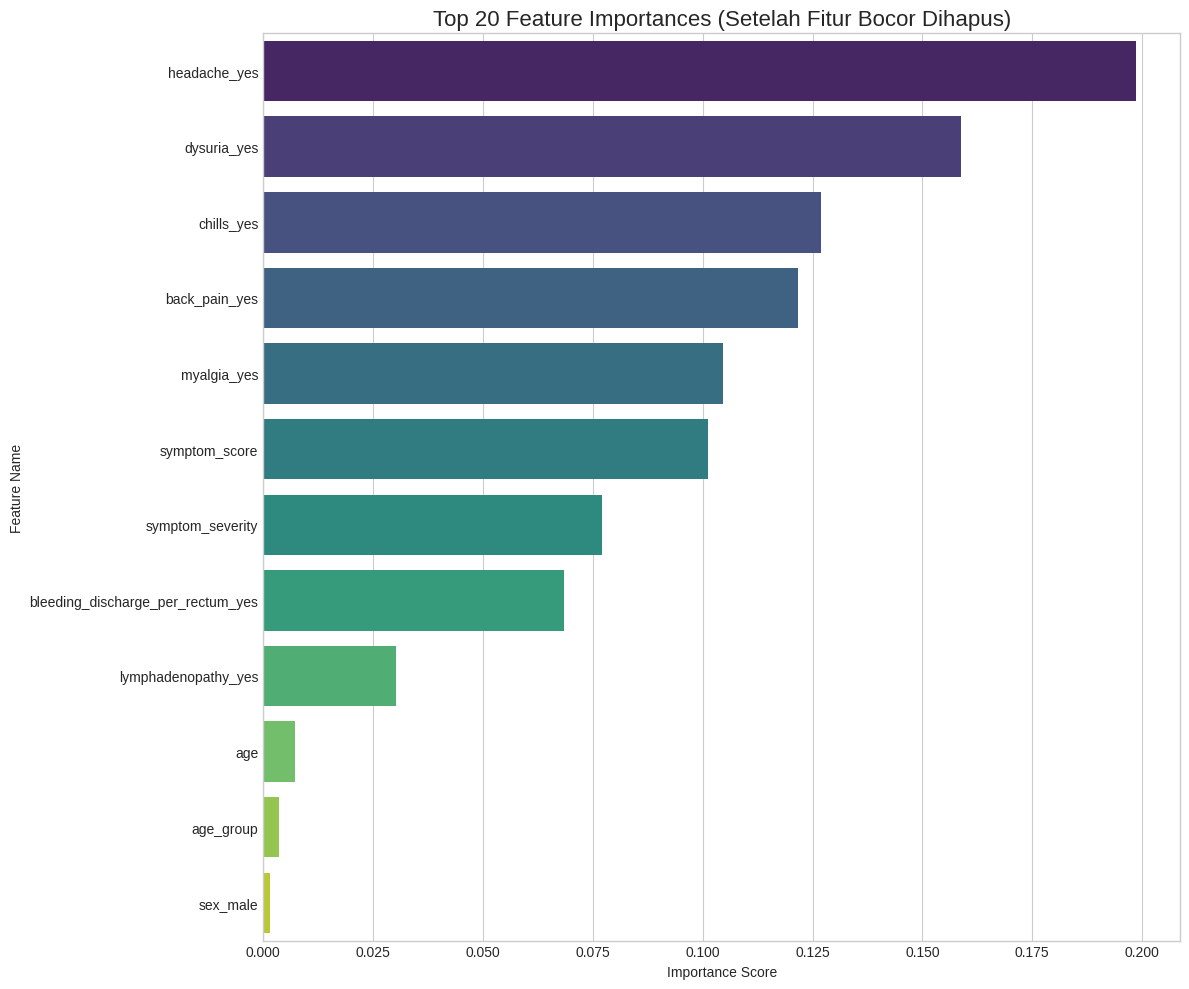


--- Fitur Paling Penting (Setelah Pembersihan) ---


,feature,importance
4,headache_yes,0.198686
9,dysuria_yes,0.158782
7,chills_yes,0.127000
6,back_pain_yes,0.121641
5,myalgia_yes,0.104553
1,symptom_score,0.101107
2,symptom_severity,0.077151
10,bleeding_discharge_per_rectum_yes,0.068546
8,lymphadenopathy_yes,0.030212
0,age,0.007218




📊 Menganalisis Korelasi pada data yang sudah bersih (X_train_final_exp)...

--- Top 20 Fitur Paling Berhubungan dengan Target (Setelah Pembersihan) ---


,TARGET
TARGET,1.000000
back_pain_yes,0.559375
chills_yes,0.555670
symptom_severity,0.470309
headache_yes,0.446109
dysuria_yes,0.431496
symptom_score,0.394235
myalgia_yes,0.369486
bleeding_discharge_per_rectum_yes,0.262104
lymphadenopathy_yes,0.054914


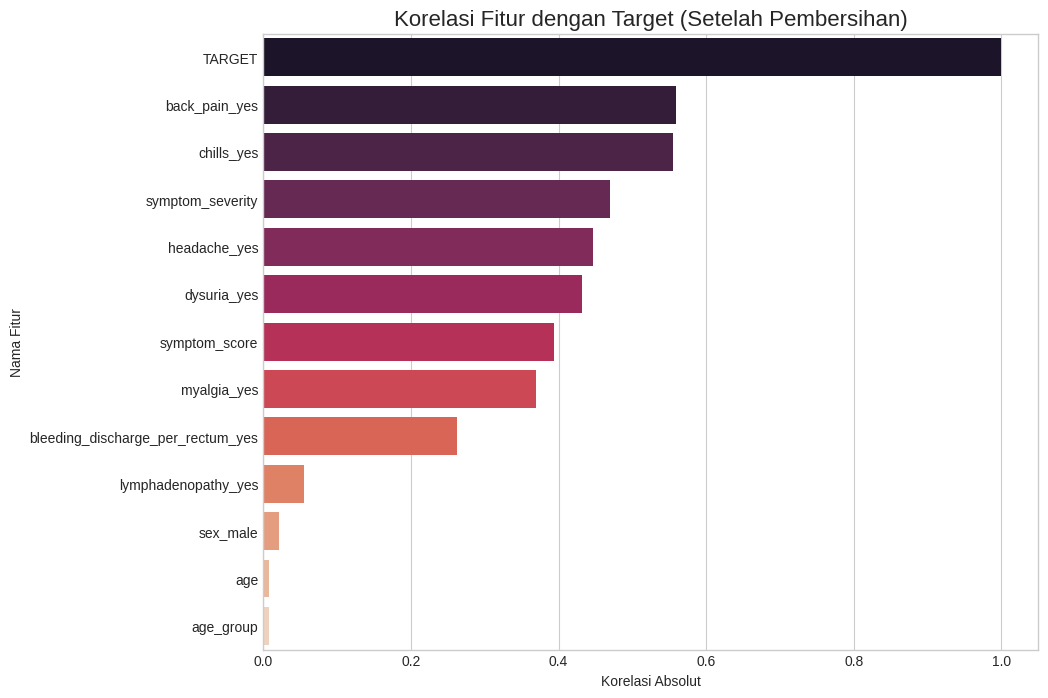

In [15]:
# =============================================================================
# ANALISIS DIAGNOSTIK PADA DATA BERSIH (EKSPERIMENTAL)
# =============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# --- 1. Analisis Feature Importance pada Data Bersih ---
print("📊 Menganalisis Feature Importance pada data yang sudah bersih (X_train_final_exp)...")

diagnostic_model = RandomForestClassifier(random_state=42)
diagnostic_model.fit(X_train_final_exp, y_train_encoded)

feature_importances = pd.DataFrame({
    'feature': X_train_final_exp.columns,
    'importance': diagnostic_model.feature_importances_
}).sort_values('importance', ascending=False)

top_20_features = feature_importances.head(20)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Feature Importances (Setelah Fitur Bocor Dihapus)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

print("\n--- Fitur Paling Penting (Setelah Pembersihan) ---")
display(top_20_features)


# --- 2. Analisis Korelasi pada Data Bersih ---
print("\n" + "="*80)
print("\n📊 Menganalisis Korelasi pada data yang sudah bersih (X_train_final_exp)...")

df_corr_exp = X_train_final_exp.copy()
df_corr_exp['TARGET'] = y_train_encoded

correlation_with_target_exp = df_corr_exp.corr()['TARGET'].abs().sort_values(ascending=False)
top_20_correlated_exp = correlation_with_target_exp.head(20)

print("\n--- Top 20 Fitur Paling Berhubungan dengan Target (Setelah Pembersihan) ---")
display(top_20_correlated_exp.to_frame())

plt.figure(figsize=(10, 8))
sns.barplot(x=top_20_correlated_exp.values, y=top_20_correlated_exp.index, palette='rocket')
plt.title('Korelasi Fitur dengan Target (Setelah Pembersihan)', fontsize=16)
plt.xlabel('Korelasi Absolut')
plt.ylabel('Nama Fitur')
plt.show()

📊 Menganalisis Feature Importance pada data yang sudah bersih (X_train_final_exp)...


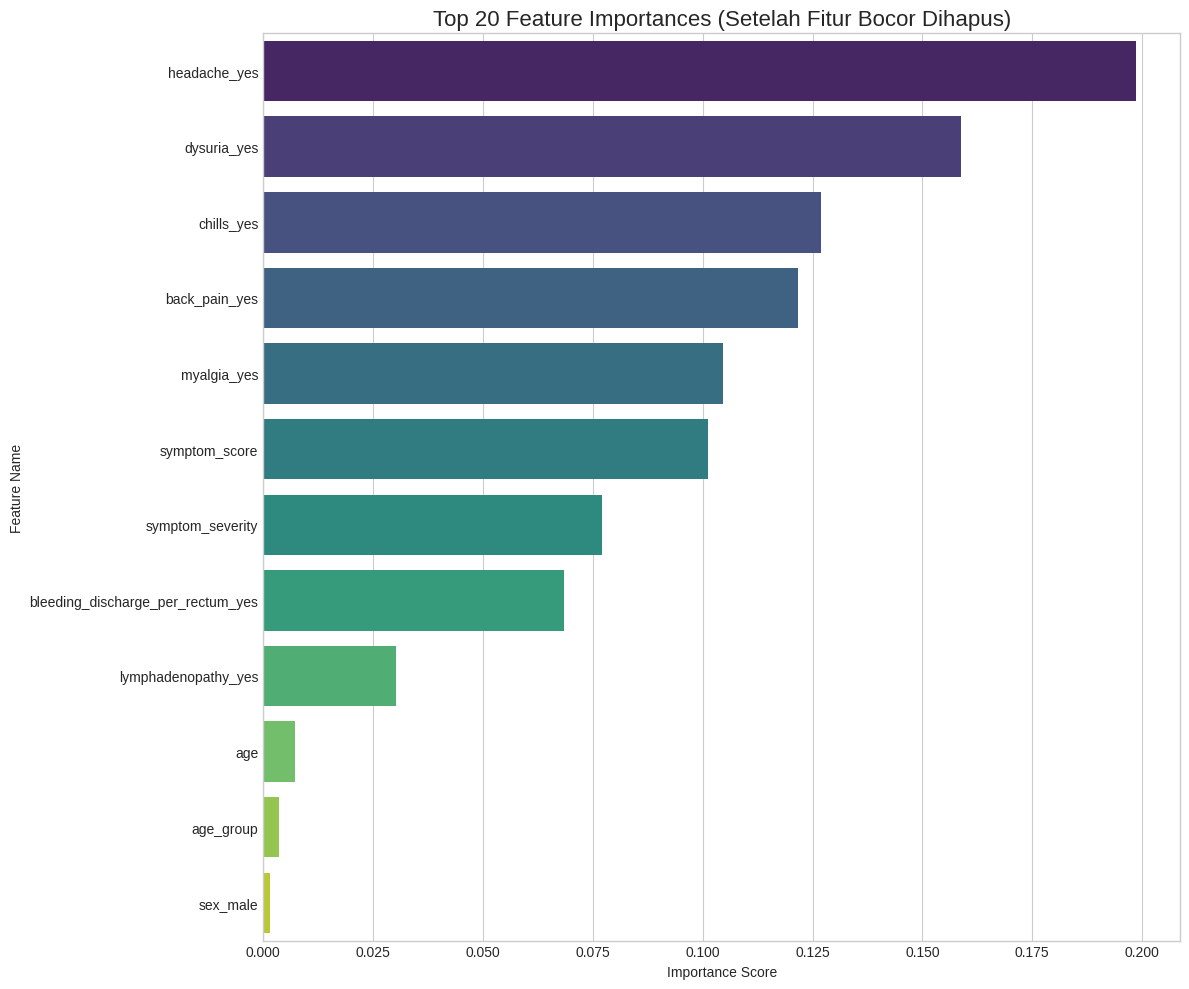


--- Fitur Paling Penting (Setelah Pembersihan) ---


,feature,importance
4,headache_yes,0.198686
9,dysuria_yes,0.158782
7,chills_yes,0.127000
6,back_pain_yes,0.121641
5,myalgia_yes,0.104553
1,symptom_score,0.101107
2,symptom_severity,0.077151
10,bleeding_discharge_per_rectum_yes,0.068546
8,lymphadenopathy_yes,0.030212
0,age,0.007218


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Latih model diagnostik pada data EKSPERIMENTAL yang sudah bersih
print("📊 Menganalisis Feature Importance pada data yang sudah bersih (X_train_final_exp)...")
diagnostic_model = RandomForestClassifier(random_state=42)
diagnostic_model.fit(X_train_final_exp, y_train_encoded)

# Buat DataFrame dari feature importances
feature_importances = pd.DataFrame({
    'feature': X_train_final_exp.columns,
    'importance': diagnostic_model.feature_importances_
}).sort_values('importance', ascending=False)

# Tampilkan 20 fitur teratas
top_20_features = feature_importances.head(20)

# Visualisasikan
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Feature Importances (Setelah Fitur Bocor Dihapus)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

print("\n--- Fitur Paling Penting (Setelah Pembersihan) ---")
display(top_20_features)

In [17]:
# =============================================================================
# STEP 12: BASELINE MODEL TRAINING (PADA DATA EKSPERIMENTAL & SMOTE)
# =============================================================================
import pandas as pd
import time
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from IPython.display import display

# --- 1. Definisi Model (Menggunakan regularisasi manual yang kuat) ---
print("\n" + "🏋️"*40)
print("STEP 12: INITIALIZING BASELINE MODELS WITH STRONG REGULARIZATION")
print("🏋️"*40)

models = {
    "Random Forest (Max Reg)": RandomForestClassifier(
        n_estimators=100, max_depth=4, min_samples_leaf=15,
        max_features='sqrt', random_state=42
    ),
    "XGBoost (Max Reg)": XGBClassifier(
        n_estimators=80, max_depth=2, learning_rate=0.01, gamma=1,
        subsample=0.6, colsample_bytree=0.6, random_state=42,
        use_label_encoder=False, eval_metric='logloss'
    ),
    "CatBoost (Max Reg)": CatBoostClassifier(
        iterations=150, depth=3, learning_rate=0.01, l2_leaf_reg=7,
        random_state=42, verbose=0
    )
}

# --- 2. Fungsi Evaluasi ---
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, feature_scenario, num_features):
    """Fungsi terpusat untuk melatih dan mengevaluasi model."""
    print("-" * 60)
    print(f"Training and Evaluating: {model_name} ({feature_scenario})")
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    preds = model.predict(X_val)
    results = {
        "Model": f"{model_name} ({feature_scenario})",
        "Accuracy": accuracy_score(y_val, preds),
        "Precision": precision_score(y_val, preds, pos_label=positive_class_index, zero_division=0),
        "Recall": recall_score(y_val, preds, pos_label=positive_class_index, zero_division=0),
        "F1-Score": f1_score(y_val, preds, pos_label=positive_class_index, zero_division=0),
        "Training Time (s)": training_time,
        "Num Features": num_features
    }
    print(f"✅ Evaluation Complete. Accuracy: {results['Accuracy']:.4f}, F1-Score: {results['F1-Score']:.4f}")
    return results

# =============================================================================
# STEP 12: TRAIN & EVALUATE BASELINE MODELS (CLEANED + BALANCED DATA)
# =============================================================================
print("\n" + "🚀"*40)
print("STEP 12: TRAINING BASELINE MODELS ON CLEANED & BALANCED FEATURES")
print("🚀"*40)

baseline_results = []
for name, model in models.items():
    baseline_results.append(
        evaluate_model(model,
                       X_train_smote, y_train_smote,
                       X_validation_final_exp, y_validation_encoded,
                       name, "Baseline (No Leakage)", X_train_smote.shape[1])
    )

# --- MENAMPILKAN TABEL HASIL ---
print("\n" + "📊"*40)
print("STEP 12: BASELINE MODEL PERFORMANCE COMPARISON (NO LEAKAGE)")
print("📊"*40)
baseline_df = pd.DataFrame(baseline_results)
display(baseline_df.style.format(precision=4).background_gradient(cmap='viridis',
                                                                  subset=['Accuracy', 'F1-Score']))



🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️
STEP 12: INITIALIZING BASELINE MODELS WITH STRONG REGULARIZATION
🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
STEP 12: TRAINING BASELINE MODELS ON CLEANED & BALANCED FEATURES
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
------------------------------------------------------------
Training and Evaluating: Random Forest (Max Reg) (Baseline (No Leakage))
✅ Evaluation Complete. Accuracy: 1.0000, F1-Score: 1.0000
------------------------------------------------------------
Training and Evaluating: XGBoost (Max Reg) (Baseline (No Leakage))
✅ Evaluation Complete. Accuracy: 0.9867, F1-Score: 0.9885
------------------------------------------------------------
Training and Evaluating: CatBoost (Max Reg) (Baseline (No Leakage))
✅ Evaluation Complete. Accuracy: 0.9867, F1-Score: 0.9885

📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
STEP 12: BASELINE

,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s),Num Features
0,Random Forest (Max Reg) (Baseline (No Leakage)),1.0000,1.0000,1.0000,1.0000,0.1718,12
1,XGBoost (Max Reg) (Baseline (No Leakage)),0.9867,1.0000,0.9773,0.9885,0.0278,12
2,CatBoost (Max Reg) (Baseline (No Leakage)),0.9867,1.0000,0.9773,0.9885,0.1146,12


In [18]:
# =============================================================================
# STEP 13: APPLYING IGWO FEATURE SELECTION (PADA DATA EKSPERIMENTAL BERSIH)
# =============================================================================
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

print("\n" + "🧬"*40)
print("STEP 13: APPLYING IMPROVED GWO (IGWO) FEATURE SELECTION")
print("🧬"*40)

# Fitness function (Tidak ada perubahan)
def fitness_function(feature_mask, X, y, model):
    selected_indices = np.where(np.array(feature_mask) == 1)[0]
    if len(selected_indices) == 0:
        return 0.0
    X_subset = X.iloc[:, selected_indices]
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
        X_subset, y, test_size=0.25, stratify=y, random_state=42
    )
    model.fit(X_train_sub, y_train_sub)
    accuracy = model.score(X_val_sub, y_val_sub)
    penalty = 0.01 * (len(selected_indices) / X.shape[1])
    return accuracy - penalty

# Kelas IGWO (Tidak ada perubahan)
class IGWOSelector:
    def __init__(self, fitness_func, num_wolves=20, max_iter=50):
        self.fitness_func = fitness_func
        self.num_wolves = num_wolves
        self.max_iter = max_iter
        self.eval_model = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)
    def run(self, X_train, y_train):
        num_features = X_train.shape[1]
        wolves = np.random.randint(0, 2, (self.num_wolves, num_features))
        alpha_pos, beta_pos, delta_pos = np.zeros(num_features), np.zeros(num_features), np.zeros(num_features)
        alpha_score, beta_score, delta_score = -np.inf, -np.inf, -np.inf
        print("Memulai proses seleksi fitur dengan IGWO...")
        for t in range(self.max_iter):
            fitness_scores = [self.fitness_func(wolf, X_train, y_train, self.eval_model) for wolf in wolves]
            for i in range(self.num_wolves):
                if fitness_scores[i] > alpha_score:
                    delta_score, delta_pos = beta_score, beta_pos.copy()
                    beta_score, beta_pos = alpha_score, alpha_pos.copy()
                    alpha_score, alpha_pos = fitness_scores[i], wolves[i].copy()
                elif fitness_scores[i] > beta_score:
                    delta_score, delta_pos = beta_score, beta_pos.copy()
                    beta_score, beta_pos = fitness_scores[i], wolves[i].copy()
                elif fitness_scores[i] > delta_score:
                    delta_score, delta_pos = fitness_scores[i], wolves[i].copy()
            a = 2 - t * (2 / self.max_iter)
            for i in range(self.num_wolves):
                r1, r2 = np.random.rand(2); A1 = 2 * a * r1 - a; C1 = 2 * r2
                D_alpha = np.abs(C1 * alpha_pos - wolves[i]); X1 = alpha_pos - A1 * D_alpha
                r1, r2 = np.random.rand(2); A2 = 2 * a * r1 - a; C2 = 2 * r2
                D_beta = np.abs(C2 * beta_pos - wolves[i]); X2 = beta_pos - A2 * D_beta
                r1, r2 = np.random.rand(2); A3 = 2 * a * r1 - a; C3 = 2 * r2
                D_delta = np.abs(C3 * delta_pos - wolves[i]); X3 = delta_pos - A3 * D_delta
                new_position_continuous = (X1 + X2 + X3) / 3.0
                sigmoid = 1 / (1 + np.exp(-10 * (new_position_continuous - 0.5)))
                wolves[i] = (sigmoid > np.random.rand(num_features)).astype(int)
            if (t + 1) % 5 == 0:
                print(f"   - Iterasi {t+1}/{self.max_iter} | Best Fitness Sejauh Ini: {alpha_score:.4f}")
        best_features_indices = np.where(alpha_pos == 1)[0]
        return X_train.columns[best_features_indices].tolist()

# =============================================================================
# EKSEKUSI IGWO (PADA DATA BERSIH)
# =============================================================================
igwo_selector = IGWOSelector(fitness_function, num_wolves=20, max_iter=50)
start_time = time.time()
# --- PERUBAHAN UTAMA: Jalankan IGWO pada data training EKSPERIMENTAL (`_exp`) ---
best_features_igwo = igwo_selector.run(X_train_final_exp, y_train_encoded)
end_time = time.time()

print(f"\n✅ IGWO selesai dalam {end_time - start_time:.2f} detik.")
print(f"   - Fitur terpilih ({len(best_features_igwo)}): {best_features_igwo}")

# --- PERUBAHAN UTAMA: Buat dataset baru dari data EKSPERIMENTAL (`_exp`) ---
X_train_selected = X_train_final_exp[best_features_igwo]
X_validation_selected = X_validation_final_exp[best_features_igwo]
X_test_selected = X_test_final_exp[best_features_igwo]

print(f"\n   - Ukuran baru X_train_selected: {X_train_selected.shape}")
print("="*80)


🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬
STEP 9: APPLYING IMPROVED GWO (IGWO) FEATURE SELECTION
🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬
Memulai proses seleksi fitur dengan IGWO...
   - Iterasi 5/50 | Best Fitness Sejauh Ini: 0.9967
   - Iterasi 10/50 | Best Fitness Sejauh Ini: 0.9975
   - Iterasi 15/50 | Best Fitness Sejauh Ini: 0.9975
   - Iterasi 20/50 | Best Fitness Sejauh Ini: 0.9975
   - Iterasi 25/50 | Best Fitness Sejauh Ini: 0.9975
   - Iterasi 30/50 | Best Fitness Sejauh Ini: 0.9975
   - Iterasi 35/50 | Best Fitness Sejauh Ini: 0.9975
   - Iterasi 40/50 | Best Fitness Sejauh Ini: 0.9975
   - Iterasi 45/50 | Best Fitness Sejauh Ini: 0.9975
   - Iterasi 50/50 | Best Fitness Sejauh Ini: 0.9975

✅ IGWO selesai dalam 64.37 detik.
   - Fitur terpilih (3): ['back_pain_yes', 'dysuria_yes', 'bleeding_discharge_per_rectum_yes']

   - Ukuran baru X_train_selected: (350, 3)


In [21]:
# =============================================================================
# STEP 14 (REVISI FINAL): RE-TRAIN & FINAL TEST DENGAN DATA BERSIH
# =============================================================================
import pandas as pd
import numpy as np
import re
from sklearn.metrics import classification_report
from IPython.display import display

print("\n" + "🏆"*40)
print("STEP 14: RE-TRAINING ON IGWO-SELECTED FEATURES (FROM CLEANED DATA)")
print("🏆"*40)

# Latih dan evaluasi model IGWO pada data yang sudah bersih dari kebocoran
# Variabel X_train_selected dibuat di Step 9 dari data _exp
# Variabel y_train_smote adalah target yang sudah seimbang
igwo_results = []
for name, model in models.items():
    # PERBAIKAN: Pastikan X_train_smote di-subset dengan benar jika IGWO memilih fitur
    # best_features_igwo mungkin kosong jika IGWO tidak menemukan fitur yang baik
    if best_features_igwo:
        X_train_for_igwo = X_train_smote[best_features_igwo]
    else:
        # Jika tidak ada fitur yg terpilih, gunakan semua fitur dari data bersih untuk perbandingan yg adil
        X_train_for_igwo = X_train_smote

    igwo_results.append(
        evaluate_model(model,
                       X_train_for_igwo,
                       y_train_smote,
                       X_validation_selected,
                       y_validation_encoded,
                       name,
                       "IGWO (No Leakage)",
                       X_train_for_igwo.shape[1])
    )

# --- Gabungkan dan Tampilkan Tabel Perbandingan Akhir ---
# 'baseline_results' sekarang berisi hasil dari data yang sudah bersih (dari Step 8 revisi)
final_comparison_df = pd.concat([pd.DataFrame(baseline_results), pd.DataFrame(igwo_results)], ignore_index=True)

print("\n" + "📊"*40)
print("FINAL RESULTS COMPARISON ON VALIDATION SET (NO LEAKAGE)")
print("📊"*40)
display(final_comparison_df.sort_values(by="F1-Score", ascending=False).style.format(precision=4).background_gradient(cmap='Greens', subset=['Accuracy', 'F1-Score']))




🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
STEP 14: RE-TRAINING ON IGWO-SELECTED FEATURES (FROM CLEANED DATA)
🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
------------------------------------------------------------
Training and Evaluating: Random Forest (Max Reg) (IGWO (No Leakage))
✅ Evaluation Complete. Accuracy: 1.0000, F1-Score: 1.0000
------------------------------------------------------------
Training and Evaluating: XGBoost (Max Reg) (IGWO (No Leakage))
✅ Evaluation Complete. Accuracy: 1.0000, F1-Score: 1.0000
------------------------------------------------------------
Training and Evaluating: CatBoost (Max Reg) (IGWO (No Leakage))
✅ Evaluation Complete. Accuracy: 1.0000, F1-Score: 1.0000

📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
FINAL RESULTS COMPARISON ON VALIDATION SET (NO LEAKAGE)
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊


,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s),Num Features
0,Random Forest (Max Reg) (Baseline (No Leakage)),1.0000,1.0000,1.0000,1.0000,0.1718,12
3,Random Forest (Max Reg) (IGWO (No Leakage)),1.0000,1.0000,1.0000,1.0000,0.2310,3
5,CatBoost (Max Reg) (IGWO (No Leakage)),1.0000,1.0000,1.0000,1.0000,0.0696,3
4,XGBoost (Max Reg) (IGWO (No Leakage)),1.0000,1.0000,1.0000,1.0000,0.0378,3
1,XGBoost (Max Reg) (Baseline (No Leakage)),0.9867,1.0000,0.9773,0.9885,0.0278,12
2,CatBoost (Max Reg) (Baseline (No Leakage)),0.9867,1.0000,0.9773,0.9885,0.1146,12


In [20]:
# =============================================================================
# STEP 15 (REVISI FINAL): FINAL TEST + OVERFITTING CHECK
# =============================================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report

print("\n" + "🏅"*40)
print("STEP 15: FINAL TEST ON UNSEEN DATA + OVERFITTING CHECK")
print("🏅"*40)

# Cari model terbaik dari tabel perbandingan akhir
best_model_row = final_comparison_df.loc[final_comparison_df['F1-Score'].idxmax()]
best_model_full_name = best_model_row['Model']
print(f"🏆 Best performing model on validation set: {best_model_full_name}")

# Ekstrak model key dari dictionary models
model_key = None
for key in models.keys():
    if key in best_model_full_name:
        model_key = key
        break

if model_key:
    final_model = models[model_key]
    print(f"   - Using model object from key: '{model_key}'")
else:
    raise KeyError(f"Could not find a matching model key for '{best_model_full_name}'")

# --- Pilih fitur sesuai baseline / IGWO ---
if "IGWO" in best_model_full_name:
    print("   - Using IGWO-selected features for final evaluation.")
    X_train_to_combine = X_train_final_exp[best_features_igwo]
    X_validation_to_combine = X_validation_final_exp[best_features_igwo]
    X_test_for_final_eval = X_test_final_exp[best_features_igwo]
else:
    print("   - Using baseline cleaned features for final evaluation.")
    X_train_to_combine = X_train_final_exp
    X_validation_to_combine = X_validation_final_exp
    X_test_for_final_eval = X_test_final_exp

# --- Re-train model on combined train+val ---
print("   - Re-fitting best model on combined training+validation data...")
combined_X = pd.concat([X_train_to_combine, X_validation_to_combine])
combined_y = np.concatenate([y_train_encoded, y_validation_encoded])
final_model.fit(combined_X, combined_y)

# --- Final prediction on test ---
final_preds = final_model.predict(X_test_for_final_eval)
print("\n--- Final Performance on Unseen Test Set ---")
print(classification_report(y_test_encoded, final_preds,
                            target_names=[str(c) for c in le.classes_],
                            zero_division=0))

# --- Extra: Cross-validation check for overfitting ---
print("\n" + "🔍"*40)
print("CROSS-VALIDATION CHECK ON TRAIN+VALIDATION DATA")
print("🔍"*40)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(final_model, combined_X, combined_y, cv=cv, scoring="f1")
print(f"Mean F1 (5-fold CV): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# --- Warning if overfitting is suspected ---
test_f1 = best_model_row["F1-Score"]  # F1 from validation
cv_f1 = cv_scores.mean()

if test_f1 >= 0.99 and cv_f1 < 0.95:
    print("⚠️ WARNING: Possible overfitting detected (Validation F1 ~1.0 but CV lower).")
elif test_f1 >= 0.99 and cv_f1 >= 0.95:
    print("✅ High F1 appears consistent across validation and CV → less risk of overfit.")
else:
    print("ℹ️ No major overfitting indication detected.")

print("\n" + "🏁"*60)
print("FINAL MODELING & EVALUATION COMPLETE!")
print("🏁"*60)



🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅
STEP 15: FINAL TEST ON UNSEEN DATA + OVERFITTING CHECK
🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅
🏆 Best performing model on validation set: Random Forest (Max Reg) (Baseline (No Leakage))
   - Using model object from key: 'Random Forest (Max Reg)'
   - Using baseline cleaned features for final evaluation.
   - Re-fitting best model on combined training+validation data...

--- Final Performance on Unseen Test Set ---
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        30
    positive       1.00      1.00      1.00        45

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75


🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍
CROSS-VALIDATION CHECK ON TRAIN+VALIDATION DATA
🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍
Mean F1 (5-fold CV): 1.0000 ± 0.0000
✅ High F1 appears consistent across validati